In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import norm


# ---------------------------------------------------------------------
# GLOBAL SETTINGS
# ---------------------------------------------------------------------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Predicted variances smaller than 0")

RNG = np.random.RandomState(0)  # fixed RNG for reproducibility

# Objective Function & Constraint

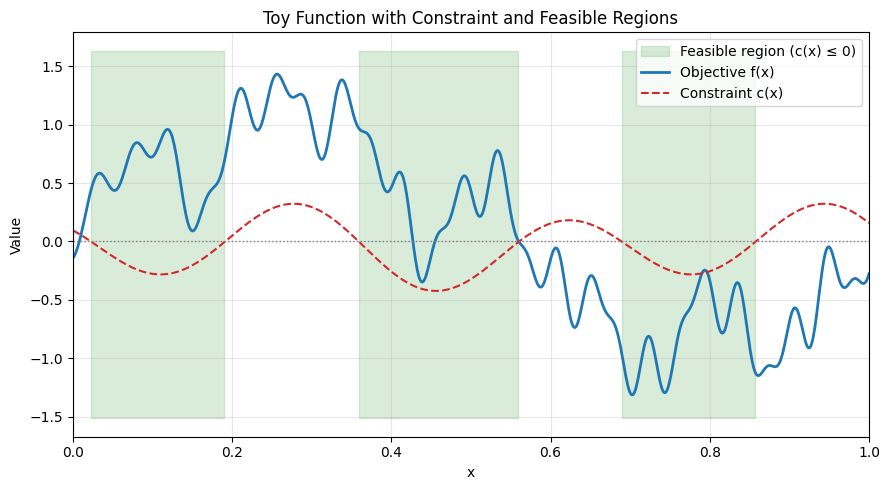

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================
# 1. Toy Function and Constraint
# ==============================================================

class ToyFunction:
    """A complex, highly multi-modal 1D deterministic test function for BO experiments."""
    def __call__(self, x):
        x = np.asarray(x, dtype=float)
        return (
            0.6 * np.sin(2 * np.pi * x)
            + 0.3 * np.sin(8 * np.pi * x + 0.3)
            + 0.25 * np.cos(14 * np.pi * (x + 0.2))
            + 0.2 * np.sin(30 * np.pi * x ** 1.2 + 0.5)
            + 0.15 * np.cos(50 * np.pi * (x ** 1.1 + 0.1))
            + 0.45 * np.exp(-60 * (x - 0.22) ** 2)
            - 0.4 * np.exp(-80 * (x - 0.78) ** 2)
            + 0.25 * np.exp(-200 * (x - 0.55) ** 4)
            - 0.15 * np.exp(-150 * (x - 0.9) ** 6)
            + 0.1 * x ** 2 - 0.05 * x ** 3
        )


class ToyConstraint:
    """A smooth nonlinear constraint: feasible if c(x) ≤ 0."""
    def __call__(self, x):
        x = np.asarray(x, dtype=float)
        return 0.3 * np.sin(6 * np.pi * (x - 0.2)) + 0.1 * np.cos(3 * np.pi * (x - 0.2)) - 0.05


# ==============================================================
# 2. Plot the Objective and Feasible Region
# ==============================================================

f = ToyFunction()
c = ToyConstraint()

X = np.linspace(0, 1, 1000).reshape(-1, 1)
y = f(X)
c_vals = c(X)

# Feasibility mask
feasible_mask = c_vals <= 0

# Plot objective and feasible regions
plt.figure(figsize=(9, 5))

# --- Feasible region shading ---
plt.fill_between(
    X.ravel(), np.min(y) - 0.2, np.max(y) + 0.2,
    where=feasible_mask.ravel(),
    color="green", alpha=0.15, label="Feasible region (c(x) ≤ 0)"
)

# --- Objective function ---
plt.plot(X, y, color="tab:blue", lw=2, label="Objective f(x)")

# --- Constraint line ---
plt.plot(X, c_vals, color="tab:red", lw=1.5, linestyle="--", label="Constraint c(x)")
plt.axhline(0, color="gray", lw=1, linestyle=":")

# --- Labels and styling ---
plt.xlabel("x")
plt.ylabel("Value")
plt.title("Toy Function with Constraint and Feasible Regions")
plt.xlim(0, 1)
plt.grid(alpha=0.3)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


# Part 1 - Unconstrained Knowledge Gradient

## Exercise 1

### Reparameterization Trick — Implementation of `reparametrize_max`

The **reparameterization trick** allows us to express the *updated GP posterior mean*  
after hypothetically observing a new sample at point $ x^{n+1} $, **without actually observing it**.

We express the new posterior mean $ \mu_y^{n+1}(x) $ as a linear function of a standard normal random variable $ Z_y $:

$$
\mu_y^{n+1}(x) = \mu_y^n(x) + \tilde{\sigma}_y^n(x, x^{n+1}) \, Z_y, 
\quad Z_y \sim \mathcal{N}(0, 1)
$$

Here, $ \tilde{\sigma}_y^n(x, x^{n+1}) $ represents the *reparameterized covariance coefficient*  
between the grid point $ x $ and the hypothetical sample $ x^{n+1} $:

$$
\tilde{\sigma}_y^n(x, x^{n+1}) = 
\frac{k_y^n(x, x^{n+1})}
{\sqrt{k_y^n(x^{n+1}, x^{n+1}) + \sigma_\epsilon^2}}
$$

where:
- $ k_y^n(\cdot, \cdot) $ is the GP posterior covariance at step $ n $,
- $ \sigma_\epsilon^2 $ is the observation noise variance,
- $ \mu_y^n(x) $ is the GP posterior mean before sampling $ x^{n+1} $.

---

### Goal

Implement a function **`reparametrize_max(X, xc, Zy)`** that:

1. Takes:
   - `X`: grid points where we evaluate the function,
   - `xc`: candidate point $ x^{n+1} $,
   - `Zy`: a set of standard normal draws $ \{Z_y^{(m)}\} $.
2. Computes for each $ Z_y^{(m)} $ a hypothetical updated posterior mean:
$$
   \mu_y^{n+1, (m)}(x) = \mu_y^n(x) + \tilde{\sigma}_y^n(x, x^{n+1}) Z_y^{(m)}
$$
3. Performs a **grid search** over $ X $ to find:
$$
   \max_x \mu_y^{n+1, (m)}(x)
$$
4. Returns the average of these maxima:
$$
   \mathbb{E}_{Z_y}\big[\max_x \mu_y^{n+1}(x)\big]
$$



In [5]:
class AcquisitionFunction:
    """Base class for acquisition functions."""

    def __init__(self, gp):
        self.gp = gp

    def compute(self, X_grid, y_best=None):
        raise NotImplementedError


class KnowledgeGradient(AcquisitionFunction):
    def __init__(self, gp, sigma_e2=0.0, M=10, rng=None):
        super().__init__(gp)
        self.sigma_e2 = sigma_e2
        self.M = M
        self.rng = np.random.RandomState(0) if rng is None else rng

    def reparametrize_max(self, X, xc, Zy):
        #TODO make em implement this
        N = X.shape[0]
        X_all = np.vstack([X, xc.reshape(1, -1)])
        _, Cov_all = self.gp.predict(X_all, return_cov=True)
        k_xprime_xc = Cov_all[:N, N]
        k_xc_xc = Cov_all[N, N]
        denom = np.sqrt(k_xc_xc + self.sigma_e2)
        denom = np.maximum(denom, 1e-12)
        tilde_sigma = k_xprime_xc / denom
        mu_n_grid = self.gp.predict(X, return_std=False).reshape(-1)

        v = []
        for zy in Zy:
            mu_next_grid = mu_n_grid + tilde_sigma * zy
            v.append(np.max(mu_next_grid))  # take max for each simulated posterior
        return np.mean(v)

        
    def compute(self, X_grid, candidates):
        mu_n_grid = self.gp.predict(X_grid, return_std=False).reshape(-1)
        baseline = np.max(mu_n_grid)
        Z = self.rng.randn(self.M)

        kg_values = np.zeros(len(candidates))
        for i, xc in enumerate(candidates):
            expected_max = self.reparametrize_max(X_grid, xc, Z)
            kg_values[i] = expected_max - baseline
        return kg_values


    def visualize_posteriors(self, X_grid, candidates, step):
        """Visualize all hypothetical posteriors at the candidate with maximum KG."""
        # --- 1. Compute KG for all candidates ---
        kg_values = self.compute(X_grid, candidates)
        idx_best = np.argmax(kg_values)
        x_best = candidates[idx_best].reshape(1, -1)
        kg_best = kg_values[idx_best]

        # --- 2. GP predictions and covariance ---
        mu_grid, _ = self.gp.predict(X_grid, return_std=True)
        _, Cov_all = self.gp.predict(np.vstack([X_grid, x_best]), return_cov=True)
        k_xprime_xbest = Cov_all[: len(X_grid), -1]
        k_xbest_xbest = Cov_all[-1, -1]
        denom = np.sqrt(k_xbest_xbest + self.sigma_e2 + 1e-12)
        tilde_sigma = k_xprime_xbest / denom

        # --- 3. Monte Carlo posterior samples ---
        Z = self.rng.randn(self.M)
        mu_next_grids = mu_grid[:, None] + tilde_sigma[:, None] * Z[None, :]

        # --- 4. Plot all samples together ---
        plt.figure(figsize=(7, 4))
        plt.plot(X_grid, mu_grid, "k--", lw=2, label="current μ(x)")
        plt.axvline(x_best, color="red", linestyle="--", label="x_best (max KG)")

        for m in range(self.M):
            mu_next = mu_next_grids[:, m]
            idx_max = np.argmax(mu_next)
            plt.plot(X_grid, mu_next, alpha=0.5, label=f"posterior {m}" if m < 3 else None)
            plt.scatter(X_grid[idx_max], mu_next[idx_max], color="tab:blue", s=25, zorder=5)

        plt.title(f"Step {step}: Posterior samples at x* (max KG = {kg_best:.4f})")
        plt.xlabel("x")
        plt.ylabel("Posterior mean μₙ₊₁(x)")
        plt.legend()
        plt.tight_layout()
        plt.show()


## Exercise 3 

### High-Value Estimates — Efficient Discretization

In the standard KG method (Scott et al., 2011), all grid points are used to form linear functions,  
but most do **not** affect the maximum envelope — wasting computation.

**High-value estimates** (Pearce et al., 2020) make this more efficient by focusing only on  
points likely to be *future maxima* of the posterior.

### Note

This method is **already implemented** for you.  
Simply run the corresponding execution cell and compare its behavior to the **fixed discretization** method implemented in **Exercise 2**.

Observe that:
- The number of linear segments (or “equations”) is greatly reduced.
- Yet, the resulting **piecewise-linear envelope** remains visually and numerically similar.

This demonstrates how adaptive discretization can reduce computational effort while maintaining accuracy.

---

### Idea

When evaluating a candidate $ x^{n+1} $:

1. Draw a few standard normal samples $ Z_y = \{z_1, \dots, z_M\} $.
2. For each $ z_i $, form the hypothetical new posterior mean:
$$
   \mu_y^{n+1}(x; z_i) = \mu_y^n(x) + \tilde{\sigma}_y^n(x, x^{n+1}) z_i
$$
3. Find the maximizing point:
$$
   x_i^* = \arg\max_x \mu_y^{n+1}(x; z_i)
$$
4. Collect these as the **discrete set**:
$$
   X^* = \{x_1^*, \dots, x_M^*\}
$$

This adaptive set $ X^* $ contains only the points that actually contribute to the expected maximum,  
making KG computation faster while preserving accuracy.




In [1]:
class HighValuePointSelector:
    """
    Implements the 'High-Value Linear Envelope' discretization from
    Pearce et al. (2020), building on Scott et al. (2011).
    """

    def __init__(self, gp, sigma_e2=0.0):
        self.gp = gp
        self.sigma_e2 = sigma_e2

    def get_high_value_points(self, X_grid, x_candidate, Z_y=None, top_k=5):
        """
        Generate the scenario-driven discrete set X_d from quantiles of Z_y,
        following Pearce et al. (2020), with broader quantiles and multiple maxima.

        Parameters
        ----------
        X_grid : (N,1) array
            Evaluation grid over the domain.
        x_candidate : (1,1) array
            Candidate point x^{n+1}.
        Z_y : array-like, optional
            Quantiles of the standard normal variable. Default: [-2.5, -1, 0, 1, 2.5].
        top_k : int, optional
            Number of top local maxima per scenario to include.

        Returns
        -------
        X_stars : (J,1) array
            Unique high-value discrete set X_d = {x_1*, ..., x_J*}.
        mu_updates : (len(Z_y), N) array
            Updated means for each scenario (for visualization).
        Z_y : (len(Z_y),) array
            The Z_y values used.
        """
        X_grid = np.atleast_2d(X_grid)
        x_candidate = np.atleast_2d(x_candidate)
        Z_y = np.array([-2.5, -1.0, 0.0, 1.0, 2.5]) if Z_y is None else np.asarray(Z_y)

        # Posterior mean and covariance at grid
        mu_grid, _ = self.gp.predict(X_grid, return_std=True)
        X_all = np.vstack([X_grid, x_candidate])
        _, Cov_all = self.gp.predict(X_all, return_cov=True)
        k_xprime_xc = Cov_all[: len(X_grid), -1]
        k_xc_xc = Cov_all[-1, -1]
        denom = np.sqrt(k_xc_xc + self.sigma_e2)
        tilde_sigma = k_xprime_xc / denom

        X_stars = []
        mu_updates = []

        for z in Z_y:
            
            mu_updated = mu_grid + tilde_sigma * z
            mu_updates.append(mu_updated)

            
            # --- Top-k maxima per scenario ---
            idx_top = np.argsort(mu_updated.ravel())[-top_k:]
            X_stars.extend(X_grid[idx_top])

        # Deduplicate (within tolerance)
        X_stars = np.unique(np.round(np.array(X_stars), 5), axis=0)
        mu_updates = np.array(mu_updates)
        return X_stars, mu_updates, Z_y

    def visualize(self, X_grid, x_candidate, X_stars, mu_updates, Z_y,  step=None):
        """
        Visualize the high-value discretization procedure (Pearce et al., 2020).
        Displays:
        - GP posterior mean ±2σ
        - Candidate x^{n+1}
        - Updated posterior means for each Z_y
        - Discretization points (X_stars) as labeled markers
        """
        print("asdasdasd")
        mu, std = self.gp.predict(X_grid, return_std=True)
        colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

        fig, ax = plt.subplots(figsize=(8, 4))

        # --- GP mean ±2σ ---
        ax.plot(X_grid, mu, "k", lw=1.5, label="Current GP mean")
        ax.fill_between(X_grid.ravel(), mu - 2 * std, mu + 2 * std, color="pink", alpha=0.3, label="±2σ")

        # --- Candidate point ---
        ax.axvline(x_candidate, color="red", lw=2, ls="--", label=r"$x^{n+1}$ (candidate)")

        # --- Updated means for each Z_y ---
        for i, (z, mu_upd) in enumerate(zip(Z_y, mu_updates)):
            color = colors[i % len(colors)]
            ax.plot(X_grid, mu_upd, color=color, lw=1.5, label=fr"Updated μ for $Z_y={z}$")
            ax.fill_between(
                X_grid.ravel(),
                mu_upd - 0.05,
                mu_upd + 0.05,
                color=color,
                alpha=0.1,
            )

        # --- Discretization points (X_stars) ---
        for i, x_star in enumerate(X_stars):
            color = colors[i % len(colors)]
            ax.scatter(
                x_star,
                self.gp.predict([x_star])[0],
                color=color,
                s=60,
                edgecolor="k",
                zorder=5,
                label=None if i > 0 else "Discretization set $X^*_i$",
            )
            ax.text(
                x_star + 0.01,
                self.gp.predict([x_star])[0] + 0.1,
                fr"$x^*_{{{i+1}}}$",
                color=color,
                fontsize=10,
            )

        ax.set_xlim(X_grid.min(), X_grid.max())
        ax.set_xlabel("x")
        ax.set_ylabel("f(x)")
        ax.set_title(f"High-Value Discretization (Step {step})")
        ax.legend(loc="upper right", fontsize=8)

        plt.tight_layout()
        plt.show()



## Exercise 2

### Completing the `_expected_max_of_lines` Integration

In the **Knowledge Gradient** computation, the function  
`_expected_max_of_lines(a, b)` evaluates the *expected maximum* of a set of linear functions
that represent the reparameterized GP posterior means for a given hypothetical observation.

Each line is of the form:

$$
\ell_j(z) = a_j + b_j z, \quad z \sim \mathcal{N}(0, 1)
$$

where:
- $ a_j = \mu_y^n(x_j) $ is the GP posterior mean at grid point $ x_j $,
- $ b_j = \tilde{\sigma}_y^n(x_j, x^{n+1}) $ is the reparameterized covariance coefficient.

The **maximum envelope** of these lines forms a *piecewise linear function* in $ z $,
and we seek the expectation of this function under the standard normal density $ \phi(z) $.

---

### Integral Expression

For each line segment where a particular line $ j $ dominates (i.e., for $ z \in [z_L, z_R] $),
the contribution to the expected maximum is:

$$
\int_{z_L}^{z_R} (a_j + b_j z)\,\phi(z)\,dz
$$

Splitting the integral:

$$
a_j \int_{z_L}^{z_R} \phi(z)\,dz
+ b_j \int_{z_L}^{z_R} z\,\phi(z)\,dz
$$

Using standard Gaussian identities:

$$
\int \phi(z)\,dz = \Phi(z),
\qquad
\int z\,\phi(z)\,dz = -\phi(z),
$$

we obtain:

$$
\int_{z_L}^{z_R} (a_j + b_j z)\,\phi(z)\,dz
= a_j \bigl(\Phi(z_R) - \Phi(z_L)\bigr)
+ b_j \bigl(\phi(z_L) - \phi(z_R)\bigr).
$$

---

### Aggregating Over All Line Segments

The piecewise linear envelope is composed of several segments,  
each corresponding to interval $[z_L, z_R]$.

Since these segments are **disjoint** and together cover all possible values of \( z \),  
we can independently compute the integral for each segment and **aggregate (sum) the results**:

$$
\mathbb{E}[\max_j (a_j + b_j Z)] 
= \sum_{j \in \text{envelope}} 
\int_{z_L^{(j)}}^{z_R^{(j)}} (a_j + b_j z)\,\phi(z)\,dz.
$$

This yields the total expected maximum value over the entire distribution of $ Z $.

    

In [28]:
class KnowledgeGradientLinearEnvelope(AcquisitionFunction):
    """
    Linear-envelope Knowledge Gradient (Frazier et al., 2009).
    Computes the KG using the exact expectation of the piecewise-linear
    max envelope over standard normal Z.
    """

    def __init__(self, gp, sigma_e2=0.0):
        super().__init__(gp)
        self.sigma_e2 = sigma_e2

    def compute(
        self,
        X_grid,
        candidates,
        use_high_value=False,
        Z_y=None,
        visualize=False,
        visualize_mode="kg",  # NEW: toggle between "var" and "kg"
        save_path=None,
        step=None,
    ):
        """
        Compute Knowledge Gradient using the linear-envelope method.

        Parameters
        ----------
        X_grid : np.ndarray
            Evaluation grid or domain points.
        candidates : np.ndarray
            Candidate query points (x^{n+1}) to evaluate KG for.
        use_high_value : bool, optional
            If True, use Pearce et al. (2020) 'High-Value' discretization.
        Z_y : array-like, optional
            Quantiles of standard normal variable for high-value points.
            Default: [-2.5, -1, 0, 1, 2.5].
        visualize : bool, optional
            If True, visualize the KG setup once (highest variance or highest KG candidate).
        visualize_mode : {'var', 'kg'}, optional
            'var' → visualize highest variance candidate (default)
            'kg'  → visualize highest KG candidate (optimal BO choice)
        save_path : str or Path, optional
            Directory to save visualization.
        step : int, optional
            Step index for file naming.
        """
        X_grid = np.atleast_2d(X_grid)
        candidates = np.atleast_2d(candidates)
        Cn = candidates.shape[0]
        mu_n_grid = self.gp.predict(X_grid, return_std=False).reshape(-1)
        baseline = np.max(mu_n_grid)
        kg_values = np.zeros(Cn)

        # --- optional high-value setup ---
        if use_high_value:
            selector = HighValuePointSelector(self.gp, sigma_e2=self.sigma_e2)
            Z_y = np.array([-2.5, -1, 0, 1, 2.5]) if Z_y is None else np.asarray(Z_y)

        # --- precompute variance for visualization candidate ---
        _, std_cand = self.gp.predict(candidates, return_std=True)
        idx_varmax = int(np.argmax(std_cand))

        # === MAIN LOOP ===
        for i, xc in enumerate(candidates):
            # (A) Determine discretization set
            if use_high_value:
                X_stars, mu_updates, Z_used = selector.get_high_value_points(X_grid, xc)
                X_d = X_stars
            else:
                X_d = X_grid
                mu_updates = None
                Z_used = None

            # (B) GP posterior terms
            mu_d, _ = self.gp.predict(X_d, return_std=True)
            X_all = np.vstack([X_d, xc.reshape(1, -1)])
            _, Cov_all = self.gp.predict(X_all, return_cov=True)
            k_xprime_xc = Cov_all[: len(X_d), -1]
            k_xc_xc = Cov_all[-1, -1]
            denom = np.sqrt(k_xc_xc + self.sigma_e2)
            denom = np.maximum(denom, 1e-12)
            tilde_sigma = k_xprime_xc / denom

            # (C) Expected max of lines
            a = mu_d
            b = tilde_sigma
            kg_values[i] = self._expected_max_of_lines(a, b) - baseline

        # === VISUALIZATION (outside loop) ===
        if visualize:
            # choose which candidate to visualize
            if visualize_mode == "var":
                idx_viz = idx_varmax
            elif visualize_mode == "kg":
                idx_viz = int(np.argmax(kg_values))
            else:
                raise ValueError("visualize_mode must be 'var' or 'kg'")

            x_viz = candidates[idx_viz]

            if use_high_value:
                X_stars, mu_updates, Z_used = selector.get_high_value_points(X_grid, x_viz)

                # visualize high-value discretization
                selector.visualize(X_grid, x_viz, X_stars, mu_updates, Z_used, step)

            # visualize the linear envelope for actual discrete set
            self.visualize(
                X_stars if use_high_value else X_grid,
                candidates,
                step=step,
                use_high_value=use_high_value,
                Z_y=Z_y,
            )

        return kg_values



    @staticmethod
    def _expected_max_of_lines(a, b):
        """
        Compute E[max_j (a_j + b_j * Z)] for Z ~ N(0,1),
        using the linear envelope integration method (Frazier et al., 2009).

        Args:
            a (np.ndarray): intercepts (shape J)
            b (np.ndarray): slopes (shape J)
        """
        # Sort lines by slope to construct the convex hull
        idx = np.argsort(b)
        a, b = a[idx], b[idx]
        m = len(a)

        t = np.full(m + 1, np.inf)
        t[0] = -np.inf
        M = [0]  # indices of lines forming the current upper envelope

        for i in range(1, m):
            while True:
                if not M:
                    # Start a new envelope if everything was popped
                    M.append(i)
                    t[len(M) - 1] = -np.inf
                    break

                j = M[-1]
                denom = b[i] - b[j]

                # Handle nearly parallel lines
                if abs(denom) < 1e-12:
                    if a[i] <= a[j]:
                        # i is below j everywhere — discard it
                        break
                    else:
                        # i dominates j — remove j and retry
                        M.pop()
                        continue

                z_int = (a[j] - a[i]) / denom

                # Ensure intersection is in increasing order
                if z_int <= t[len(M) - 1]:
                    M.pop()
                    continue
                else:
                    t[len(M)] = z_int
                    M.append(i)
                    break

        t[len(M)] = np.inf  # last boundary

        # --- Integrate the envelope ---
        Emax = 0.0
        for k in range(len(M)):
            j = M[k]
            zL, zR = t[k], t[k + 1]
            a_j, b_j = a[j], b[j]
            #Make em compute
            PhiL, PhiR = norm.cdf([zL, zR])
            phiL, phiR = norm.pdf([zL, zR])
            Emax += a_j * (PhiR - PhiL) + b_j * (phiL - phiR)

        return Emax
    
    
    def visualize(self, X_grid, candidates, step=None, use_high_value=False, Z_y=None):
        """
        Visualize the linear-envelope KG intuition:
        (a) GP posterior over domain X
        (b) Linear functions μ_j + σ_j * Z and their max envelope.

        Always plots for the candidate with the **highest KG value**.
        """
        # --- (1) Compute KG values for all candidates ---
        kg_values = np.zeros(len(candidates))
        mu_n_grid = self.gp.predict(X_grid, return_std=False).reshape(-1)
        baseline = np.max(mu_n_grid)

        for i, xc in enumerate(candidates):
            X_d = X_grid
            mu_d, _ = self.gp.predict(X_d, return_std=True)
            X_all = np.vstack([X_d, xc.reshape(1, -1)])
            _, Cov_all = self.gp.predict(X_all, return_cov=True)
            k_xprime_xc = Cov_all[: len(X_d), -1]
            k_xc_xc = Cov_all[-1, -1]
            denom = np.sqrt(k_xc_xc + self.sigma_e2)
            denom = np.maximum(denom, 1e-12)
            tilde_sigma = k_xprime_xc / denom

            a = mu_d
            b = tilde_sigma
            kg_values[i] = self._expected_max_of_lines(a, b) - baseline

        # --- (2) Choose candidate with max KG ---
        idx_best = np.argmax(kg_values)
        x_star = candidates[idx_best].reshape(1, -1)
        kg_best = kg_values[idx_best]

        # --- (3) GP posterior over domain ---
        mu_grid, std_grid = self.gp.predict(X_grid, return_std=True)

        # --- (4) Discretization set ---
        if use_high_value:
            selector = HighValuePointSelector(self.gp, sigma_e2=self.sigma_e2)
            Z_y = np.array([-1, 0, 1]) if Z_y is None else np.asarray(Z_y)
            X_d, mu_updates, _ = selector.get_high_value_points(X_grid, x_star, Z_y)
        else:
            X_d = X_grid

        # --- (5) Compute tilde_sigma for each discrete point ---
        X_all = np.vstack([X_d, x_star])
        _, Cov_all = self.gp.predict(X_all, return_cov=True)
        k_xprime_xc = Cov_all[: len(X_d), -1]
        k_xc_xc = Cov_all[-1, -1]
        denom = np.sqrt(k_xc_xc + self.sigma_e2)
        tilde_sigma = k_xprime_xc / denom
        mu_d, _ = self.gp.predict(X_d, return_std=True)

        # --- (6) Z_y axis for visualization ---
        z_vals = np.linspace(-3, 3, 200)
        lines = np.array([mu_d + tilde_sigma * z for z in z_vals])  # (Nz, |X_d|)
        envelope = lines.max(axis=1)

        # --- (7) Plot ---
        fig, axes = plt.subplots(1, 2, figsize=(11, 4))

        # (a) GP posterior and discretization set
        axes[0].plot(X_grid, mu_grid, "k", lw=1.5, label="GP mean")
        axes[0].fill_between(
            X_grid.ravel(),
            mu_grid - 2 * std_grid,
            mu_grid + 2 * std_grid,
            color="pink",
            alpha=0.4,
        )
        axes[0].axvline(x_star, color="red", lw=2, linestyle="--", label=r"$x^*$ (max KG)")
        axes[0].scatter(X_d, self.gp.predict(X_d), color="red", s=50, edgecolor="k", label=r"$X_d$")
        axes[0].set_title(f"(a) GP posterior (Step {step}, max KG = {kg_best:.4f})")
        axes[0].set_xlabel("x")
        axes[0].set_ylabel("f(x)")
        axes[0].legend()
        axes[0].set_xlim(X_grid.min(), X_grid.max())

        # (b) Linear functions μ^{n+1}(x_j) vs Z_y
        for j in range(len(X_d)):
            axes[1].plot(z_vals, mu_d[j] + tilde_sigma[j] * z_vals, color="gray", lw=1)
        axes[1].plot(z_vals, envelope, color="red", lw=2.5, label=r"Envelope: $\max_x \mu^{n+1}_y(x)$")

        axes[1].set_title(r"(b) Linear functions for discrete set $X_d$")
        axes[1].set_xlabel(r"$Z_y$")
        axes[1].set_ylabel(r"$\mu^{n+1}_y(x)$")
        axes[1].legend()

        plt.tight_layout()
        plt.show()


## BO Implementation

In [29]:
class BayesianOptimizer:
    def __init__(
        self,
        func,
        acq_type="kg",
        run_id=1,
        init_points=5,
        n_steps=8,
        m_mc=10,
        grid_n=200,
        plot_kg_posteriors=False,
        use_high_value= False
    ):
        self.func = func
        self.use_high_value= use_high_value
        self.acq_type = acq_type.lower()
        self.n_steps = n_steps
        self.m_mc = m_mc
        self.grid_n = grid_n
        self.plot_kg_posteriors = plot_kg_posteriors

        base_dir = f"runs/{self.acq_type}/run{run_id:03d}"
        self.run_dir = Path(base_dir)
        self.run_dir.mkdir(parents=True, exist_ok=True)
        self.log_path = self.run_dir / "progress.json"

        self.progress_log = []
        self.X_grid = np.linspace(0, 1, grid_n).reshape(-1, 1)
        self.candidates = np.linspace(0, 1, 101).reshape(-1, 1)

        # deterministic initialization
        self.X_train = np.linspace(0, 1, init_points).reshape(-1, 1)
        self.y_train = func(self.X_train).ravel()

    def _fit_gp(self):
        kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e3))
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            alpha=1e-10,
            normalize_y=True,
            random_state=0,
        )
        gpr.fit(self.X_train, self.y_train)
        return gpr

    def _visualize(self, gpr, acq_values, x_next, step):
        """Show true function, GP posterior, and acquisition function."""
        X_plot = np.linspace(0, 1, self.grid_n).reshape(-1, 1)
        mu, std = gpr.predict(X_plot, return_std=True)
        true_y = self.func(X_plot)

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))

        # (1) True function
        axes[0].plot(X_plot, true_y, "k", label="True f(x)")
        axes[0].scatter(self.X_train, self.y_train, color="tab:blue", marker="x")
        axes[0].set_title(f"True Function (Step {step})")
        axes[0].set_xlim(0, 1)
        axes[0].legend()

        # (2) GP posterior
        axes[1].plot(X_plot, mu, color="tab:orange", label="GP mean")
        axes[1].fill_between(
            X_plot.ravel(), mu - 2 * std, mu + 2 * std, color="tab:orange", alpha=0.2
        )
        axes[1].scatter(self.X_train, self.y_train, color="k", s=15)
        axes[1].set_title("GP Posterior ±2σ")
        axes[1].set_xlim(0, 1)
        axes[1].legend()

        # (3) Acquisition function
        axes[2].plot(self.candidates, acq_values, color="tab:green")
        axes[2].axvline(x_next, color="red", linestyle="--", label=f"max {self.acq_type.upper()}")
        axes[2].legend()
        axes[2].set_xlim(0, 1)
        axes[2].set_title(self.acq_type.upper())

        plt.tight_layout()
        plt.show()

    def _visualize_kg_posteriors(self, gpr, step):
        """Show all hypothetical posteriors for the candidate with maximum KG."""
        # Compute Knowledge Gradient values
        kg = self.acquisition.compute(self.X_grid, self.candidates)
        idx_best = np.argmax(kg)
        x_best = self.candidates[idx_best].reshape(1, -1)
        kg_best = kg[idx_best]

        # GP mean and covariance for the chosen candidate
        mu_grid, _ = gpr.predict(self.X_grid, return_std=True)
        _, Cov_all = gpr.predict(np.vstack([self.X_grid, x_best]), return_cov=True)
        k_xprime_xc = Cov_all[: len(self.X_grid), -1]
        k_xc_xc = Cov_all[-1, -1]
        denom = np.sqrt(k_xc_xc + 1e-12)
        tilde_sigma = k_xprime_xc / denom

        # Monte Carlo posterior samples
        Z = np.random.randn(self.m_mc)
        mu_next_grids = mu_grid[:, None] + tilde_sigma[:, None] * Z[None, :]

        # Plot all in one figure
        plt.figure(figsize=(7, 4))
        plt.plot(self.X_grid, mu_grid, "k--", lw=2, label="current μ(x)")
        plt.axvline(x_best, color="red", linestyle="--", label="x_best (max KG)")

        for m in range(self.m_mc):
            mu_next = mu_next_grids[:, m]
            idx_max = np.argmax(mu_next)
            plt.plot(self.X_grid, mu_next, alpha=0.5)
            plt.scatter(self.X_grid[idx_max], mu_next[idx_max], color="tab:blue", s=25, zorder=5)

        plt.title(f"Step {step}: Posterior samples at x* (max KG = {kg_best:.4f})")
        plt.xlabel("x")
        plt.ylabel("Posterior mean μₙ₊₁(x)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    def _log_step(self, step, x_next, y_next, max_val):
        self.progress_log.append(
            {
                "step": step,
                "x_next": float(np.ravel(x_next)[0]),
                "y_next": float(np.ravel(y_next)[0]),
                "acq_value": max_val,
            }
        )
    def _plot_progress(self):
        """Plot optimization progress after all steps."""
        if not self.progress_log:
            print("No progress recorded.")
            return

        steps = [entry["step"] for entry in self.progress_log]
        y_values = [entry["y_next"] for entry in self.progress_log]
        acq_values = [entry["acq_value"] for entry in self.progress_log]

        fig, ax1 = plt.subplots(figsize=(7, 4))

        # Primary y-axis: objective values
        ax1.plot(steps, y_values, "o-", color="tab:blue", label="Observed y_next")
        ax1.set_xlabel("Step")
        ax1.set_ylabel("Observed value f(x)", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")

        # Secondary y-axis: acquisition values
        ax2 = ax1.twinx()
        ax2.plot(steps, acq_values, "s--", color="tab:green", alpha=0.7, label="Acquisition value")
        ax2.set_ylabel("Acquisition value", color="tab:green")
        ax2.tick_params(axis="y", labelcolor="tab:green")

        plt.title("Optimization Progress")
        fig.tight_layout()
        plt.show()



    def run(self):
        for step in range(self.n_steps):
            print("------ STEP ",step," --------")
            gpr = self._fit_gp()

            if self.acq_type == "kg":
                acq = KnowledgeGradient(gpr, sigma_e2=0.0, M=self.m_mc, rng=RNG)
                acq_values = acq.compute(self.X_grid, self.candidates)
                if self.plot_kg_posteriors:
                    acq.visualize_posteriors(self.X_grid, self.candidates, step)
            elif self.acq_type == "kg-linear":
                acq = KnowledgeGradientLinearEnvelope(gpr, sigma_e2=0.0)
                #Do i incorporate that here?
                acq_values = acq.compute(
                self.X_grid,
                self.candidates,
                use_high_value=self.use_high_value,
                visualize=self.plot_kg_posteriors,
                step=step,
            )

            # elif self.acq_type == "ei":
            #     acq = ExpectedImprovement(gpr)
            #     y_best = np.max(self.y_train)
            #     acq_values = acq.compute(self.candidates, y_best)
            else:
                raise ValueError(f"Unknown acquisition type: {self.acq_type}")

            idx_best = np.argmax(acq_values)
            x_next = self.candidates[idx_best]
            y_next = self.func(x_next)
            max_val = float(acq_values[idx_best])

            self._visualize(gpr, acq_values, x_next, step)
            self._log_step(step, x_next, y_next, max_val)
            

            # Update dataset
            self.X_train = np.vstack([self.X_train, x_next])
            self.y_train = np.append(self.y_train, y_next)
        self._plot_progress()


## Part 1 Executions

### Excercise 1 Execution

------ STEP  0  --------


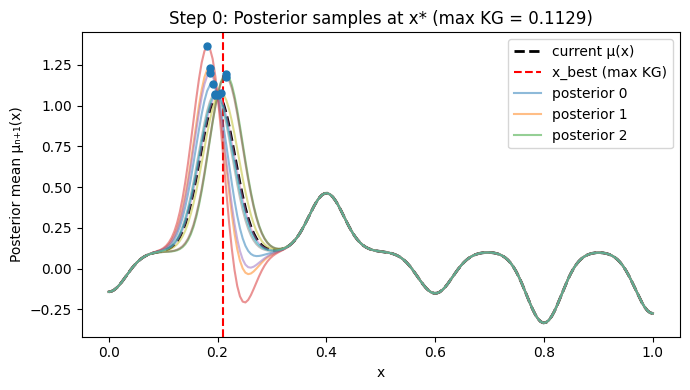

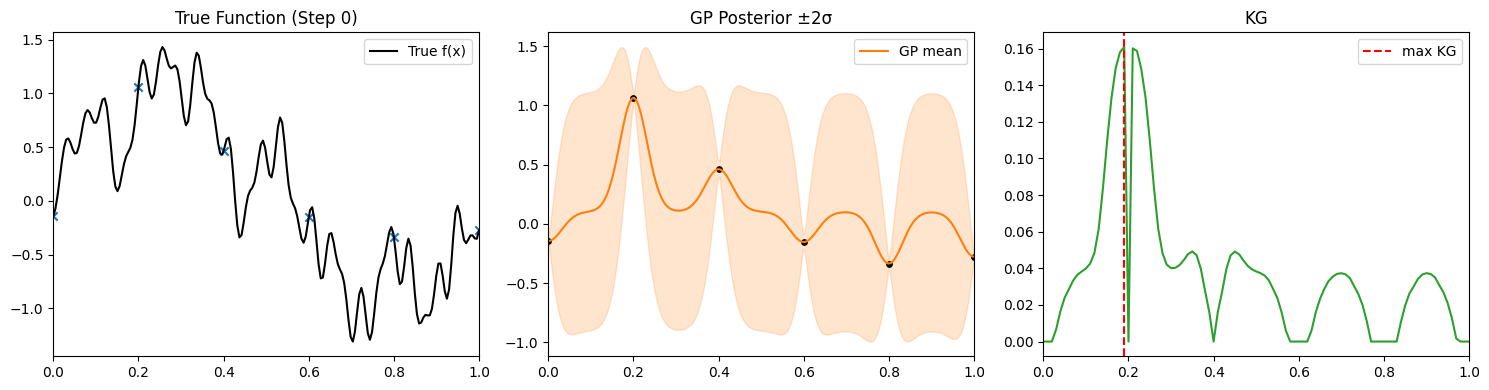

------ STEP  1  --------


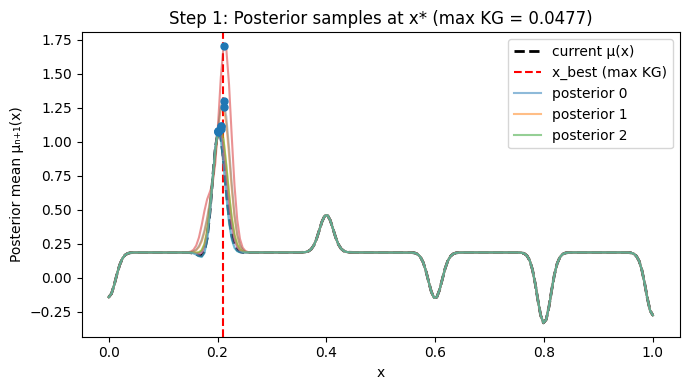

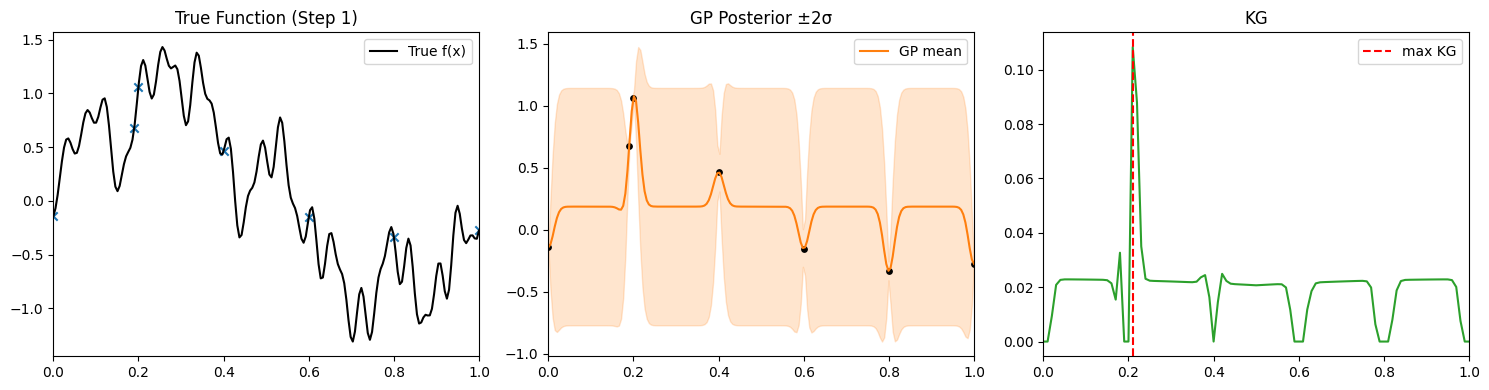

------ STEP  2  --------


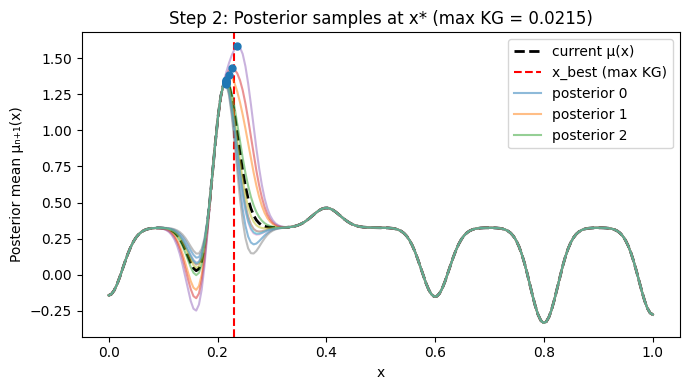

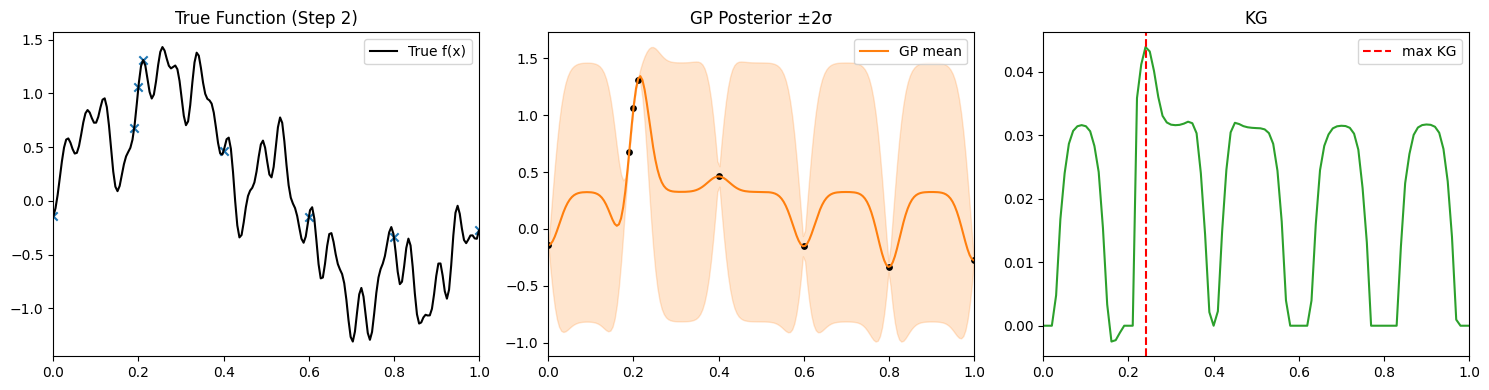

------ STEP  3  --------


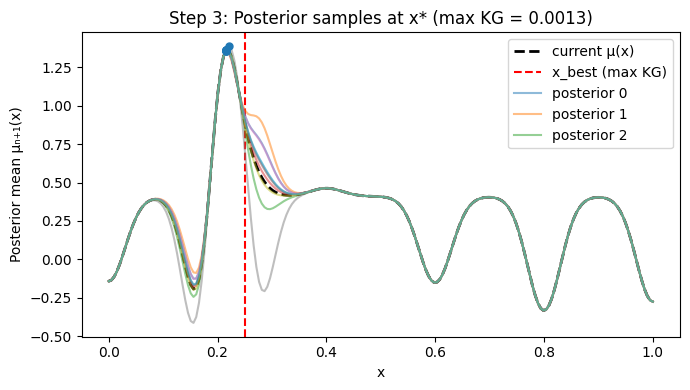

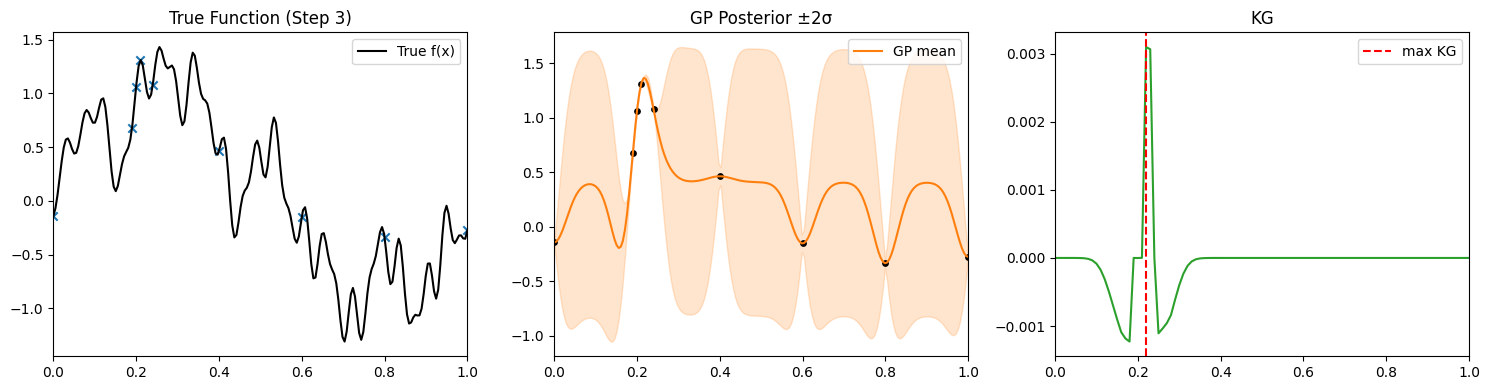

------ STEP  4  --------


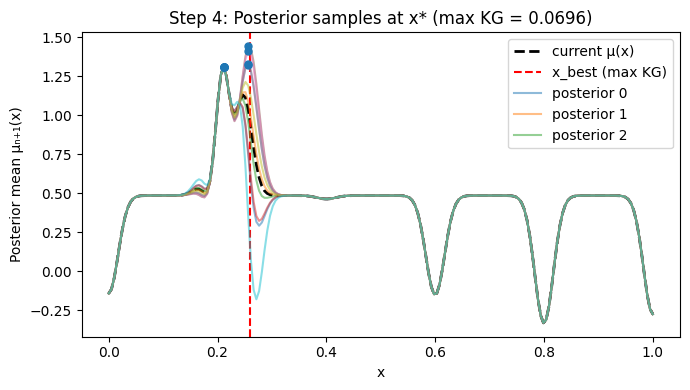

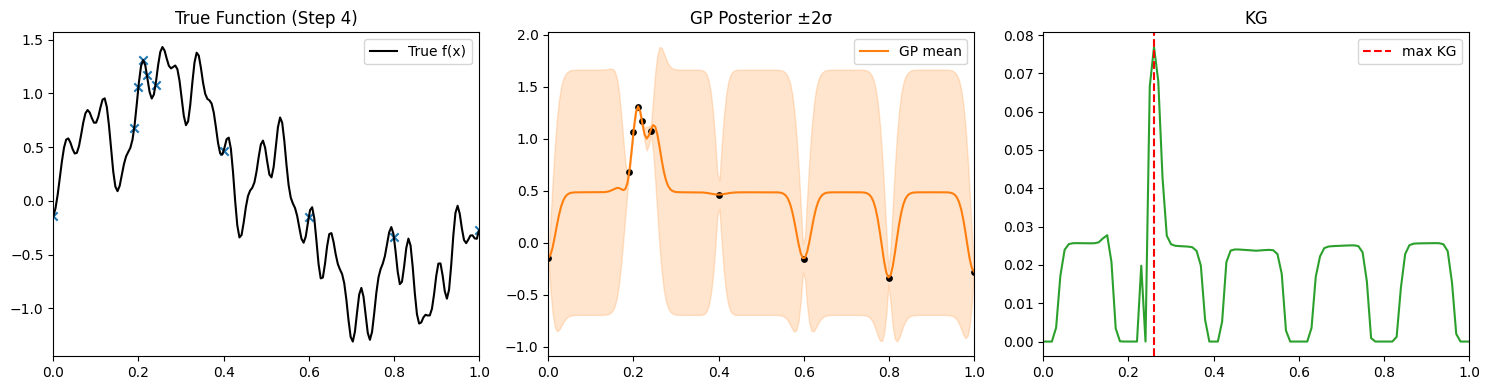

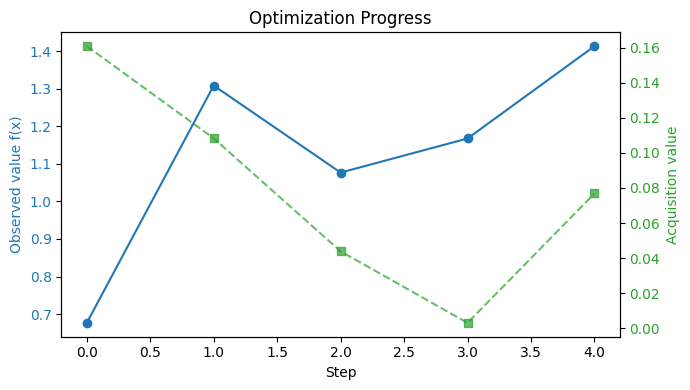

Finished KG optimization. Results in runs/kg/run002


In [29]:
kg_opt = BayesianOptimizer(func=f, acq_type="kg", run_id=2, n_steps=5, init_points=6, plot_kg_posteriors=True, use_high_value= False)
kg_opt.run()

### Exercise 2 Execution

------ STEP  0  --------


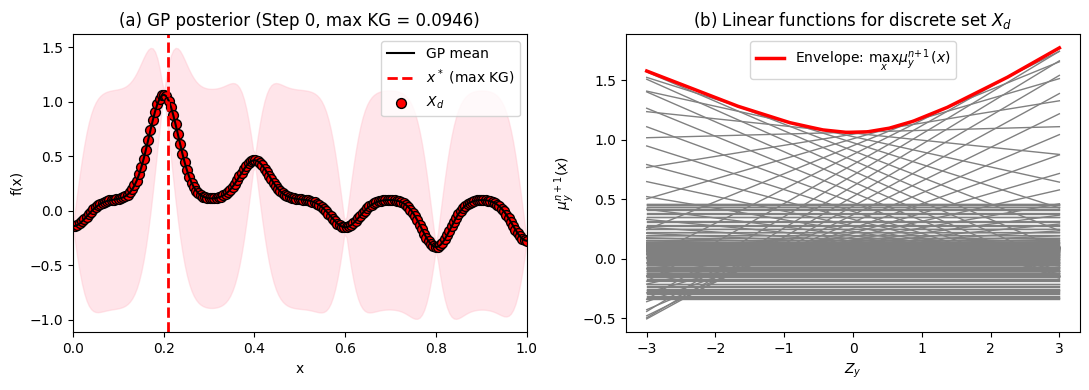

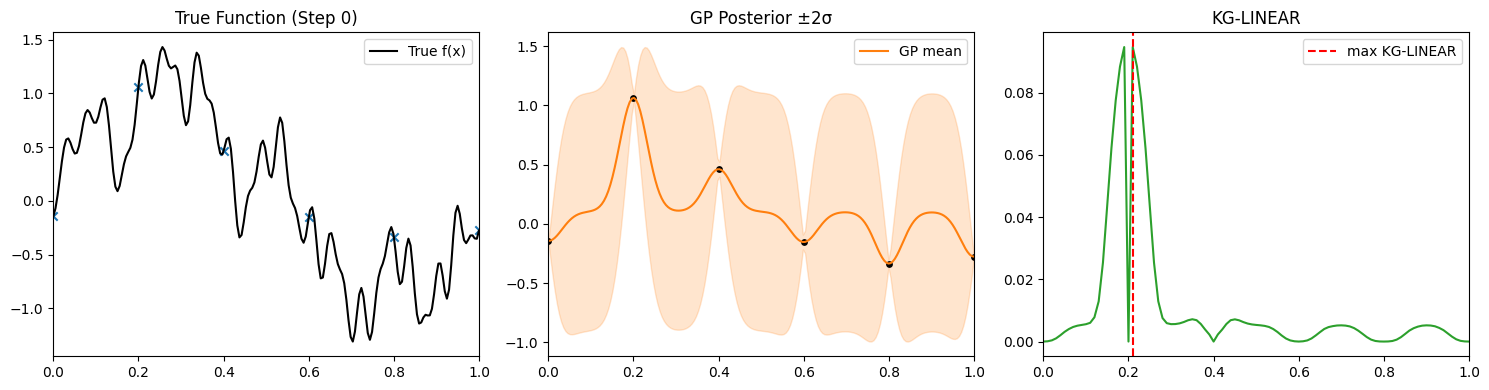

------ STEP  1  --------


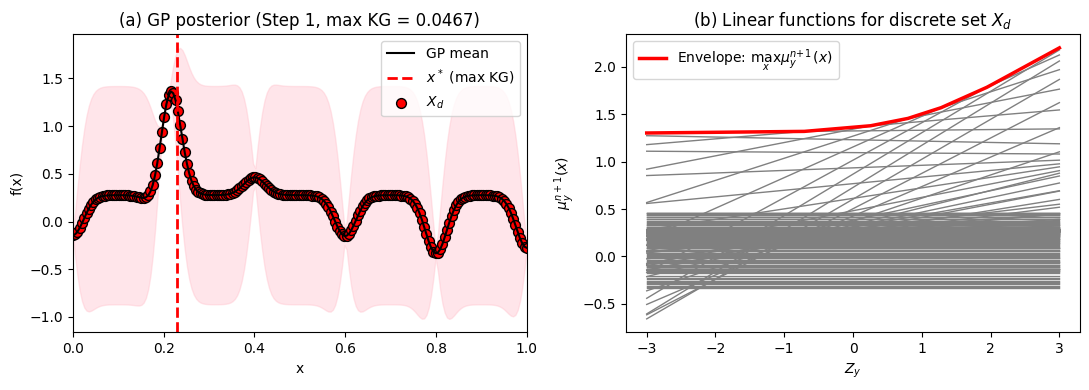

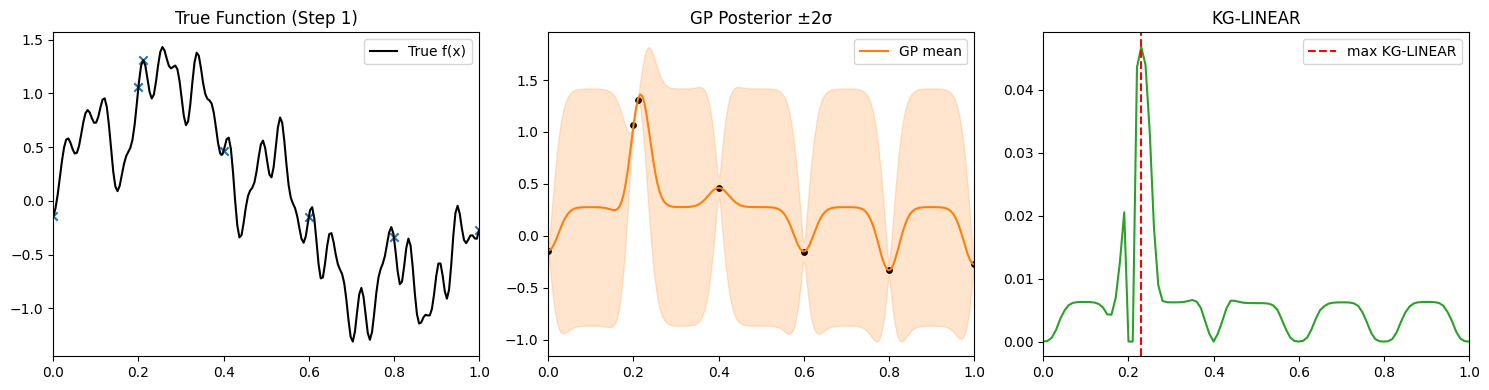

------ STEP  2  --------


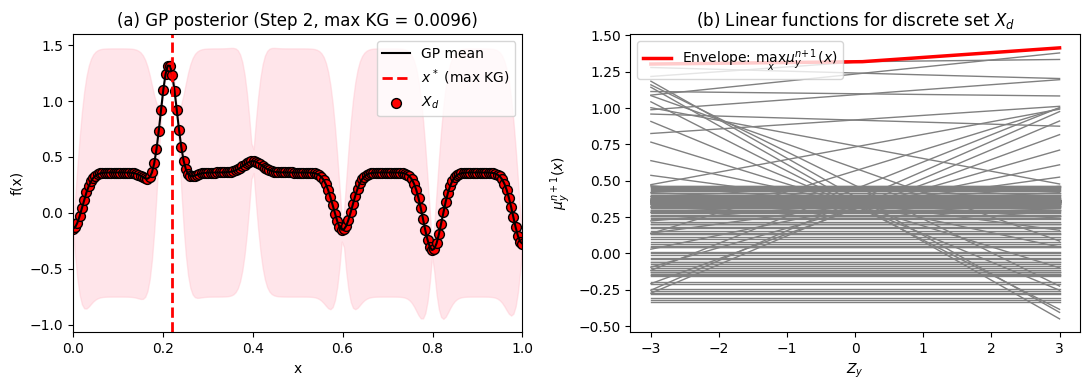

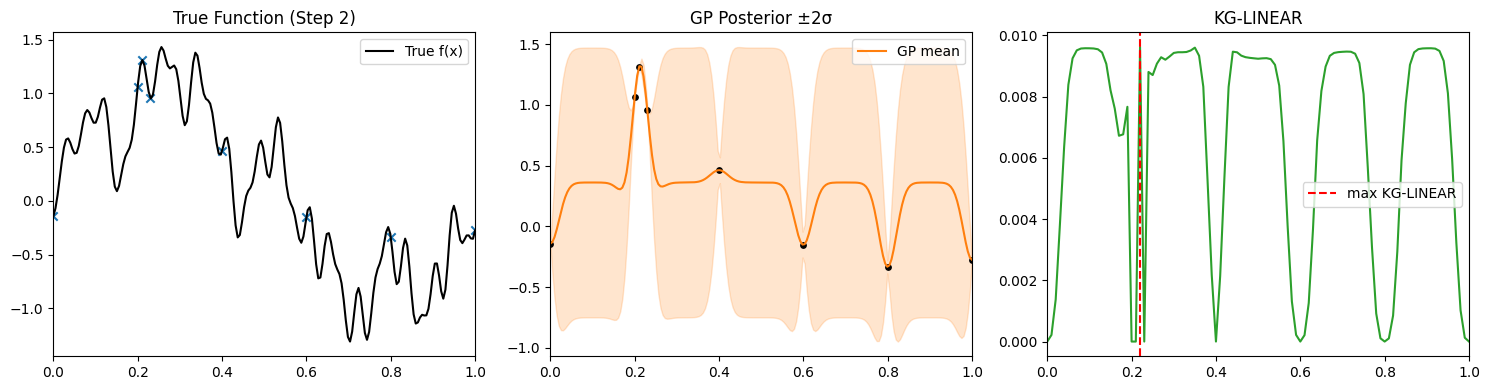

------ STEP  3  --------


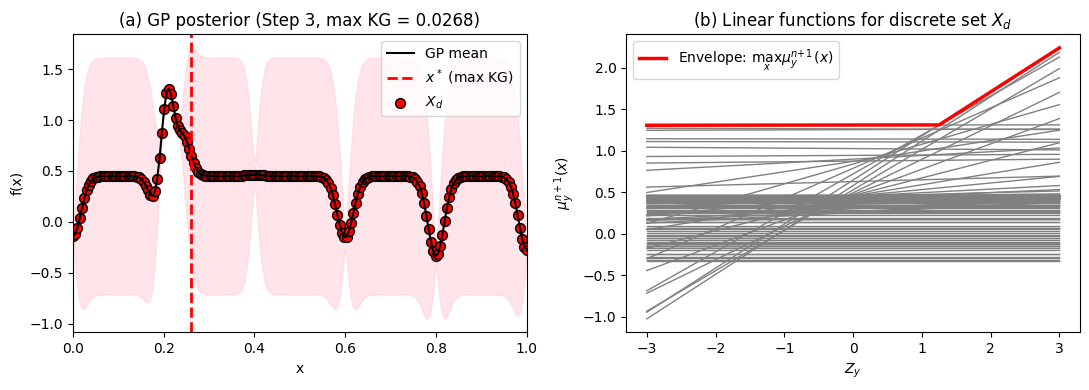

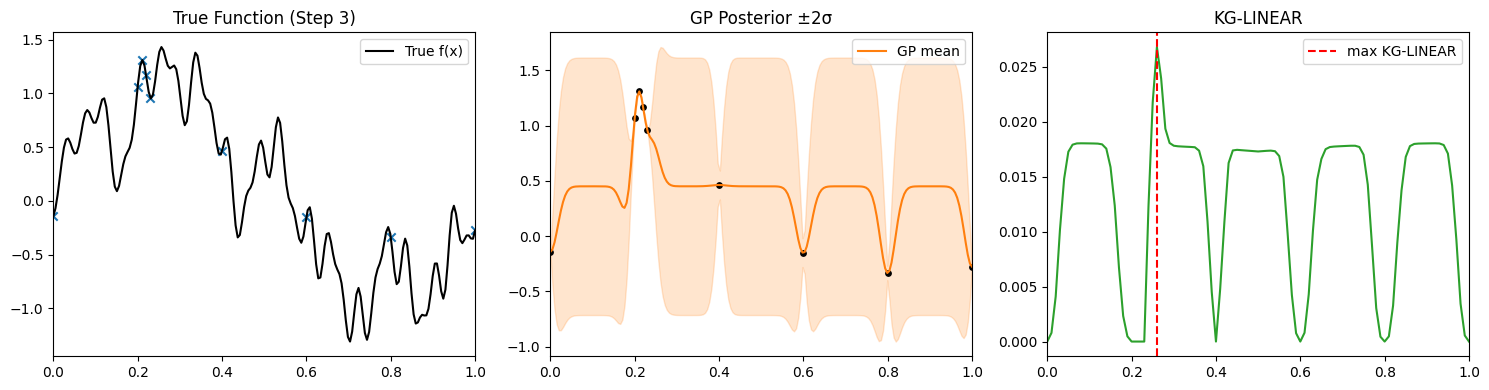

------ STEP  4  --------


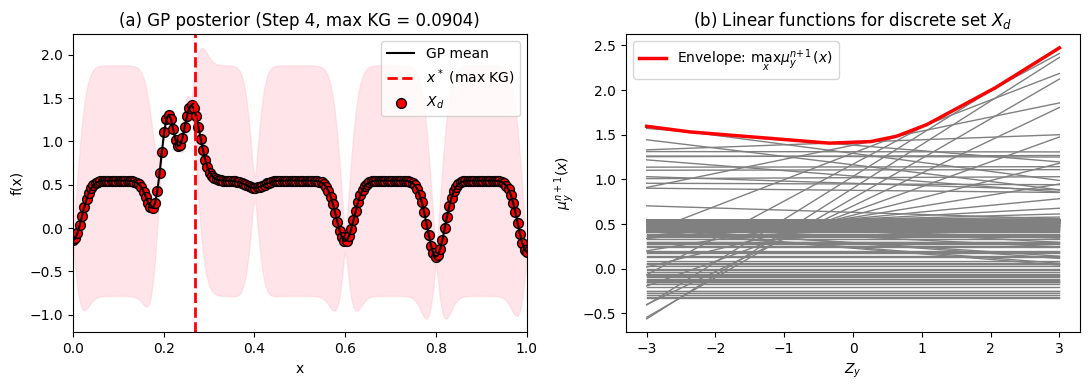

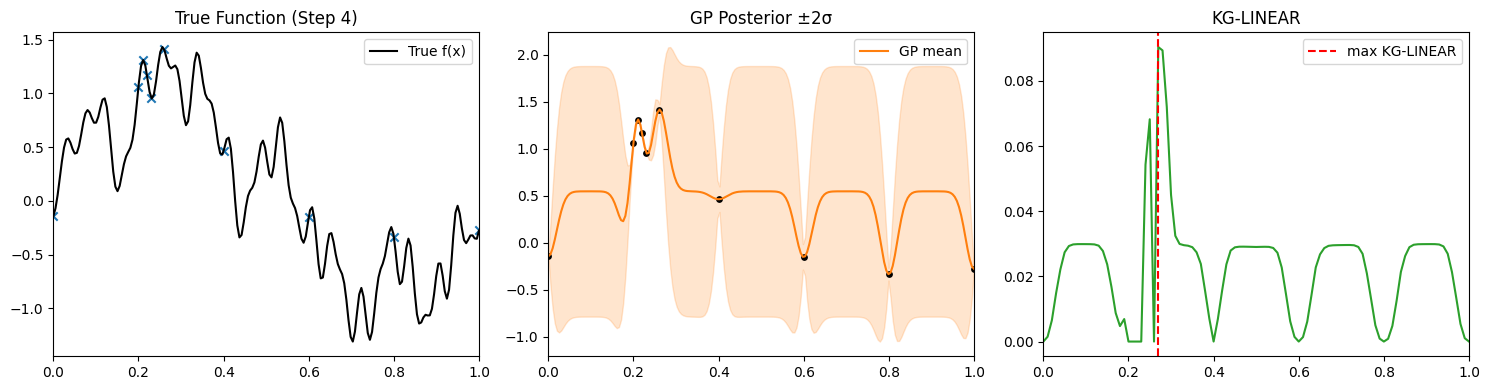

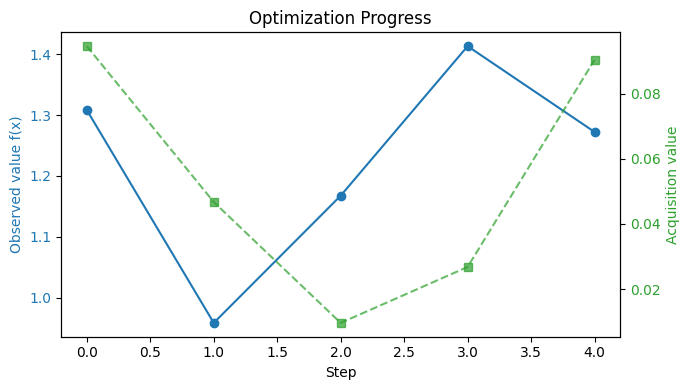

In [30]:
kg_opt = BayesianOptimizer(func=f, acq_type="kg-linear", run_id=2, n_steps=5, init_points=6, plot_kg_posteriors=True, use_high_value= False)
kg_opt.run()

### Exercise 3 Execution

------ STEP  0  --------
asdasdasd


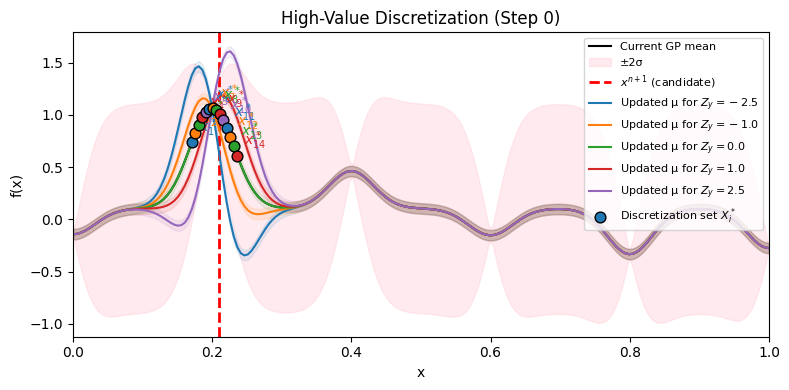

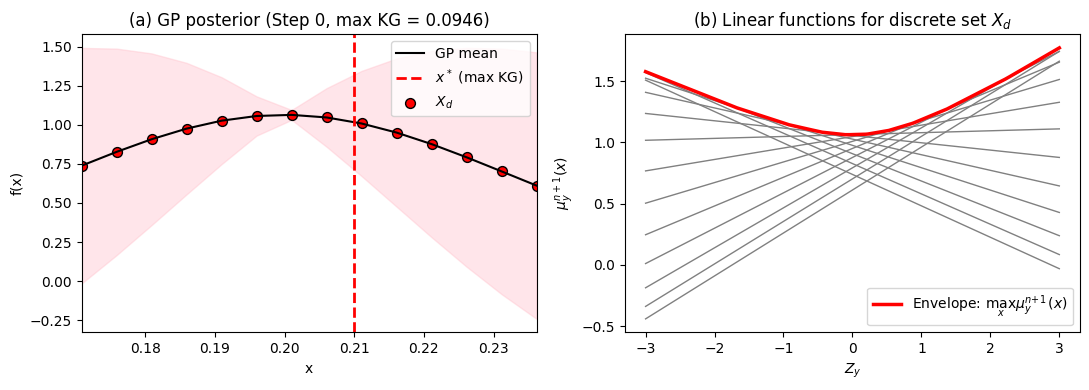

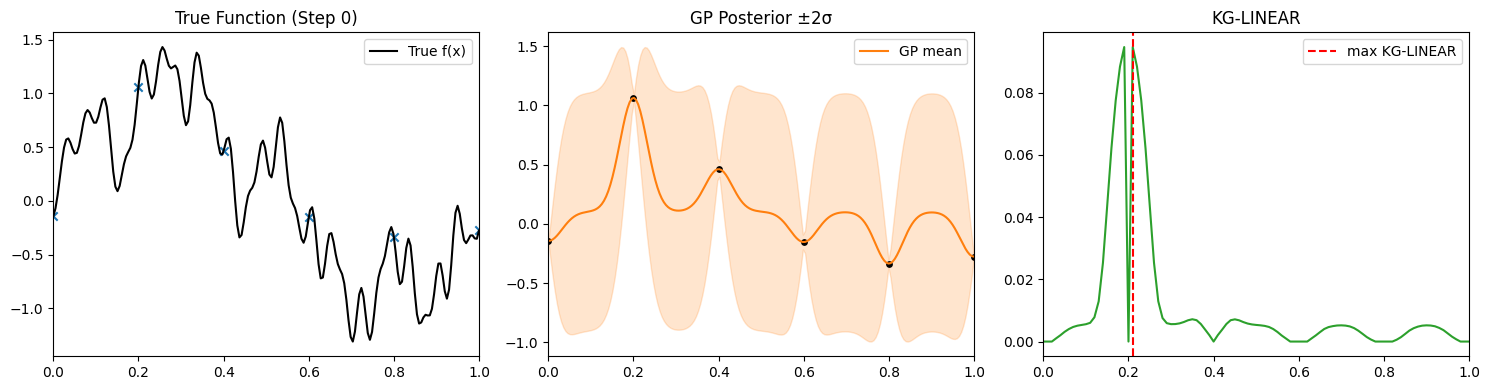

------ STEP  1  --------
asdasdasd


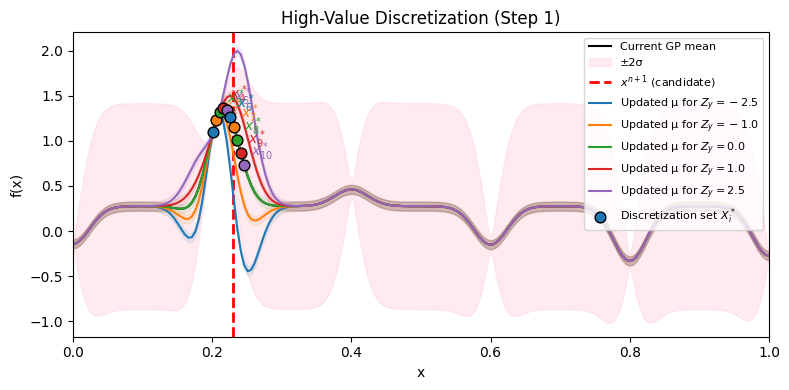

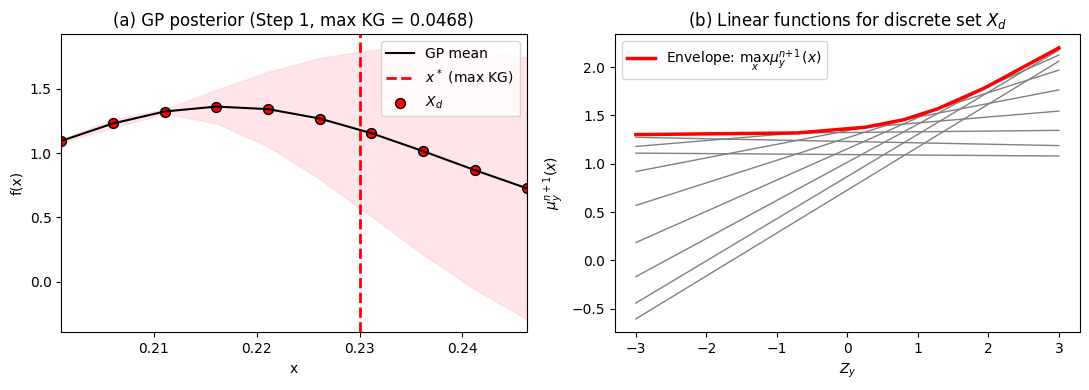

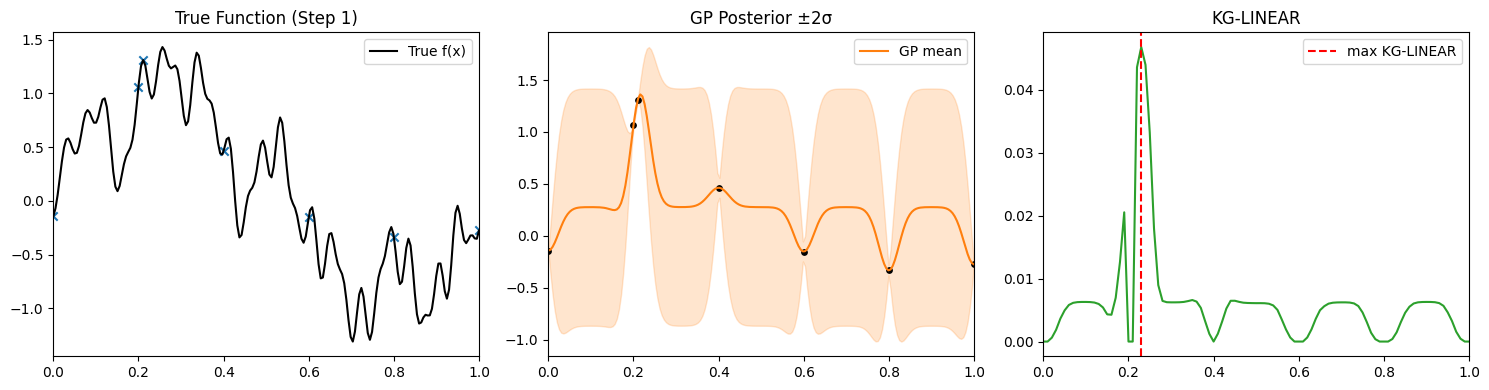

------ STEP  2  --------
asdasdasd


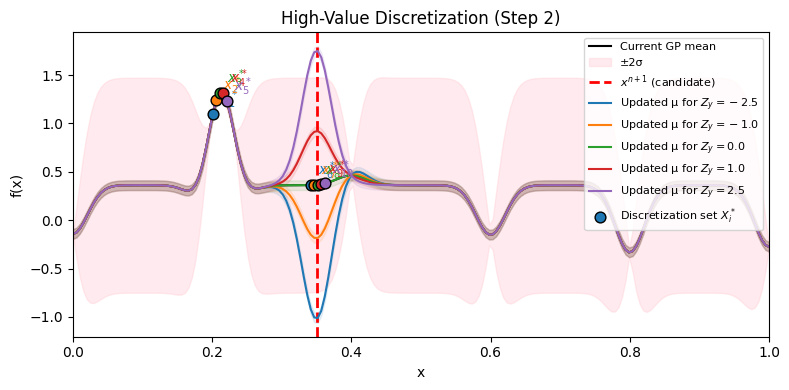

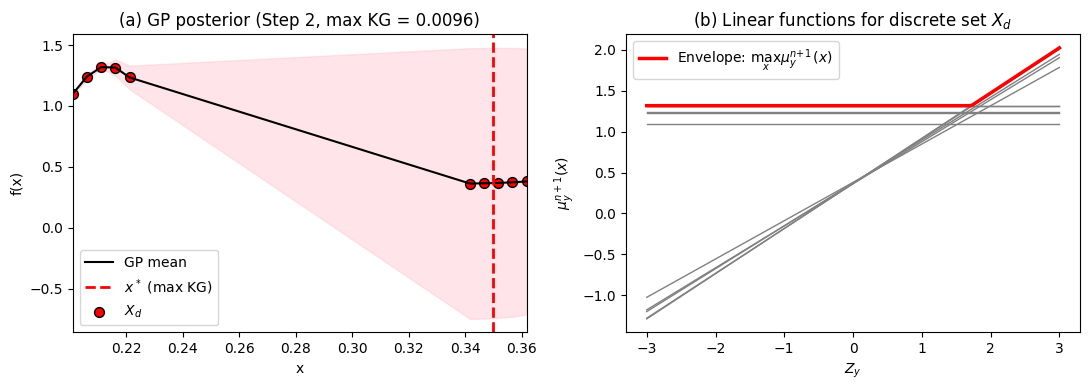

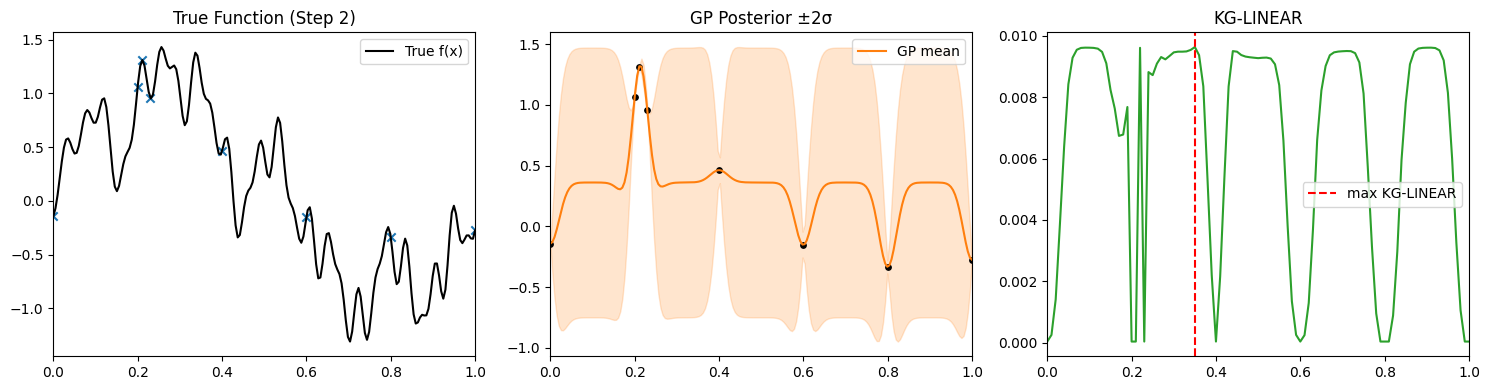

------ STEP  3  --------
asdasdasd


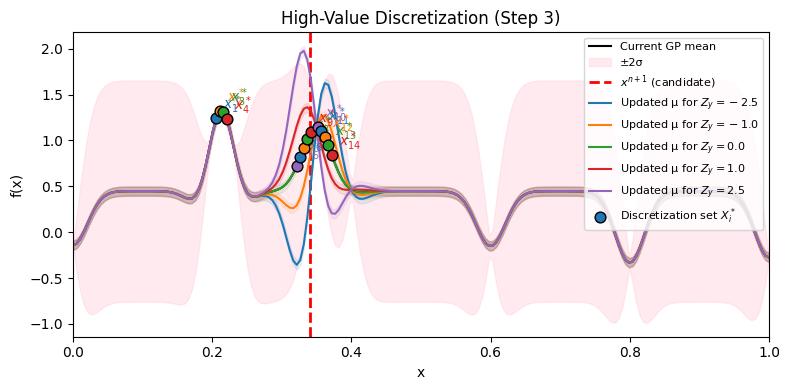

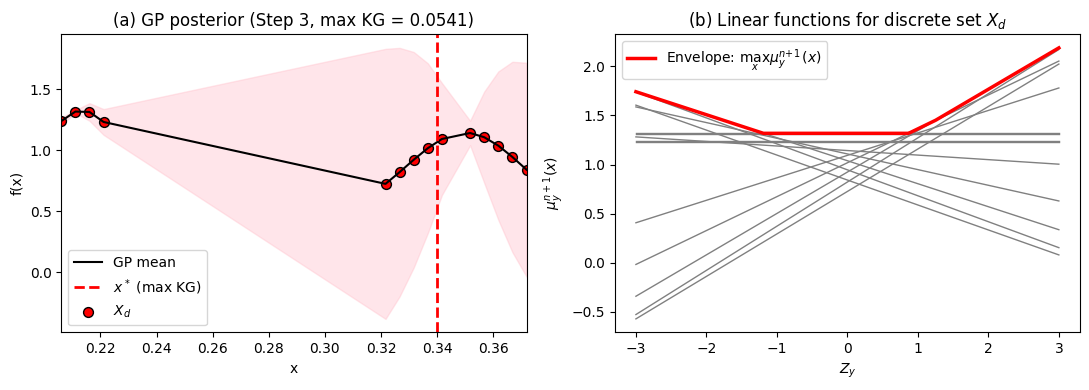

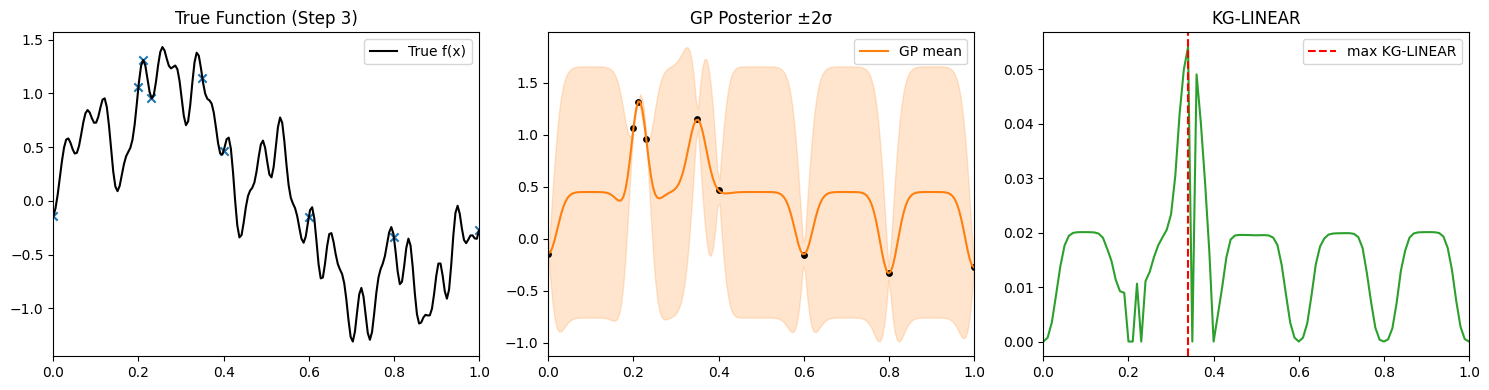

------ STEP  4  --------
asdasdasd


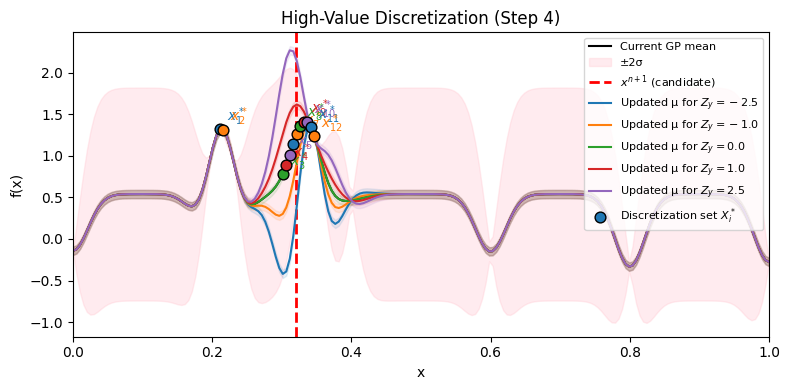

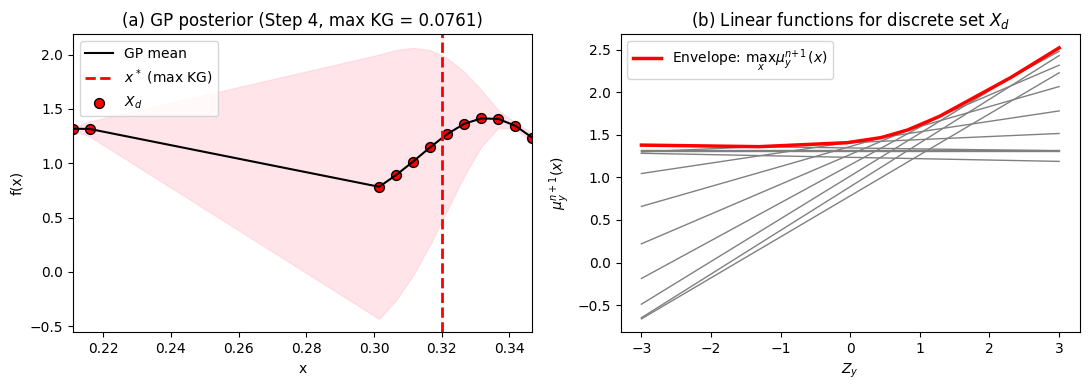

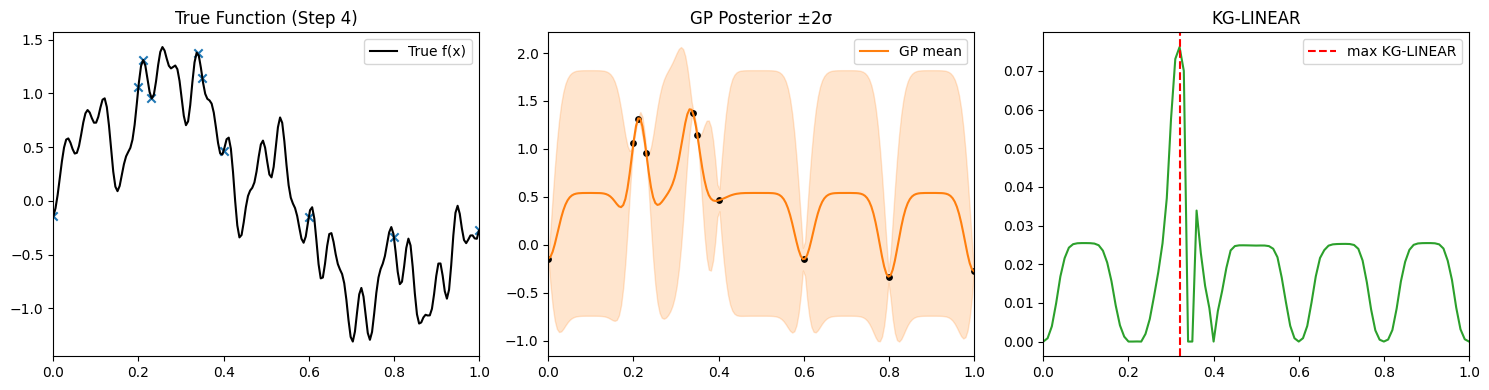

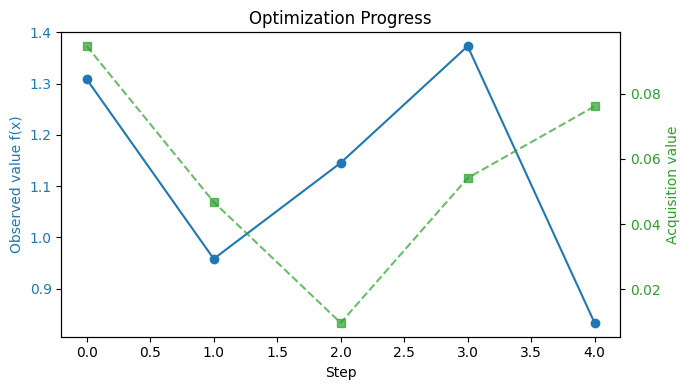

In [31]:
kg_opt = BayesianOptimizer(func=f, acq_type="kg-linear", run_id=2, n_steps=5, init_points=6, plot_kg_posteriors=True, use_high_value= True)
kg_opt.run()

# Part 2 Constrained Knowledge Gradient

## Excercise 2.1

In this exercise, you will implement the **constrained Knowledge Gradient (cKG)** term:

$$
\mathrm{cKG}(x) = 
\mathbb{E}_{Z_c, Z_y} \left[
\underbrace{
\max_{x' \in \mathcal{X}} 
\left\{
\left[ 
\mu_y^n(x') + \tilde{\sigma}_y(x', x^{n+1}) Z_y 
\right]
\mathrm{PF}^{n+1}(x'; x^{n+1}, Z_c)
\right\}
}_{\text{New best penalized posterior mean}}
- 
\mu_y^n(x_r)
\mathrm{PF}^{n+1}(x_r^n; x^{n+1}, Z_c)
\;\middle|\;
x^{n+1} = x
\right].
$$

The **baseline** term

$$
\mu_y^n(x_r)
\mathrm{PF}^{n+1}(x_r^n; x^{n+1}, Z_c)
$$

has already been computed.  
Your task is to implement the expected **new best penalized posterior mean** and then **subtract the baseline**.

---

### Expected new best penalized mean

For each candidate $x$ (the hypothetical next sample $x^{n+1}$), estimate

$$
\mathbb{E}_{Z_y,Z_c}\Big[
\max_{x'\in\mathcal{X}}
\Big(
\mu_y^n(x') + \tilde{\sigma}_y(x',x) Z_y
\Big)
\cdot
\mathrm{PF}^{n+1}(x';x,Z_c)
\Big].
$$

We approximate this expectation via Monte Carlo over $Z_y, Z_c \sim \mathcal{N}(0,1)$,  
and then subtract the precomputed baseline for the same candidate $x$.

---

### Reparametrized update equations

You will use the **reparametrization trick** to simulate how posterior means and variances change after sampling at $x^{n+1}$.

**Objective mean update:**

$$
\mu_y^{n+1}(x') = \mu_y^n(x') + \tilde{\sigma}_y(x', x^{n+1}) Z_y
$$

**Constraint mean update:**

$$
\mu_c^{n+1}(x') = \mu_c^n(x') + \tilde{\sigma}_c(x', x^{n+1}) Z_c
$$

**Constraint variance update:**

$$
\big(\sigma_c^{n+1}(x')\big)^2 = \big(\sigma_c^n(x')\big)^2 - \tilde{\sigma}_c(x', x^{n+1})^2
$$

**Probability of feasibility (for a single constraint):**

$$
\mathrm{PF}^{n+1}(x';x^{n+1},Z_c)
=
\Phi\!\left(-\frac{\mu_c^{n+1}(x')}{\sigma_c^{n+1}(x')}\right)
$$

For multiple independent constraints, use the product of all individual probabilities of feasibility.

---

### Important Notes

- The class **already provides**:
  - `self._tilde_sigma(...)` for computing $\tilde{\sigma}_y$ and $\tilde{\sigma}_c$.
  - `self.probability_of_feasibility(...)` for computing $\mathrm{PF}(x)$.
- Reuse these functions rather than reimplementing them.
- The Monte Carlo averaging approximates the outer expectation over $(Z_y, Z_c)$.
- The Monte Carlo averaging runs for **i = 0, 1, ..., self.M - 1**,  
  and uses the same index `i` for both $Z_y[i]$ and $Z_c[i]$.
  Each pair $(Z_y[i], Z_c[i])$ represents one joint realization of the random outcomes.
  For each Monte Carlo sample $i = 0, 1, \ldots, \text{self.M} - 1$, use $(Z_y[i], Z_c[i])$ to compute one possible realization of the **maximum penalized posterior mean**:

$$
v_i =
\max_{x' \in \mathcal{X}}
\Big\{
\big[
\mu_y^n(x') + \tilde{\sigma}_y(x', x^{n+1}) Z_y[i]
\big]
\cdot
\Phi\!\left(
-\frac{
\mu_c^n(x') + \tilde{\sigma}_c(x', x^{n+1}) Z_c[i]
}{
\sqrt{(\sigma_c^n(x'))^2 - \tilde{\sigma}_c(x', x^{n+1})^2}
}
\right)
\Big\}.
$$

Store each $v_i$ in the array `vals`, then later compute

$$
\mathbb{E}[v_i] \approx \frac{1}{M} \sum_{i=0}^{M-1} v_i
$$

to approximate the expected new best penalized posterior mean.



In [ ]:
class ConstrainedKnowledgeGradient:
    """Constrained Knowledge Gradient acquisition function for one constraint."""

    def __init__(self, gp_obj, gp_con, M=10, sigma_e2_obj=0.0, sigma_e2_con=0.0, rng=None):
        self.gp_obj = gp_obj
        self.gp_con = gp_con
        self.M = M
        self.sigma_e2_obj = sigma_e2_obj
        self.sigma_e2_con = sigma_e2_con
        self.rng = np.random.RandomState(3) if rng is None else rng

    # --- Gaussian Process utilities ---
    def _posterior_mu_std(self, gp, X):
        mu, std = gp.predict(X, return_std=True)
        return mu.ravel(), std.ravel()

    def _tilde_sigma(self, gp, X, xc, sigma_e2):
        """Compute the correlation vector between x' and the new point xc."""
        X_all = np.vstack([X, xc.reshape(1, -1)])
        _, Cov = gp.predict(X_all, return_cov=True)
        k_xprime_xc = Cov[:-1, -1]
        var_xc = Cov[-1, -1]
        denom = np.sqrt(np.maximum(var_xc + sigma_e2, 1e-12))
        return k_xprime_xc / denom

    # --- Probability of Feasibility (single constraint) ---
    def probability_of_feasibility(self, mu_c, std_c):
        return norm.cdf(-mu_c / (std_c + 1e-12))

    # --- Core acquisition computation ---
    def compute(self, X_grid, candidates):
        """
        Compute cKG(x_c) = E[max_x' μ_y^{n+1}(x') * PF^{n+1}(x')] - max_x' μ_y^n(x') * PF^n(x')
        """
        X_grid = np.atleast_2d(X_grid)
        candidates = np.atleast_2d(candidates)

        # 1️⃣ Current posteriors
        mu_y, _ = self._posterior_mu_std(self.gp_obj, X_grid)
        mu_c, std_c = self._posterior_mu_std(self.gp_con, X_grid)

        # 2️⃣ Current feasibility-weighted objective
        PF_n = self.probability_of_feasibility(mu_c, std_c)
        baseline = np.max(mu_y * PF_n)

        # 3️⃣ Monte Carlo samples for objective and constraint outcomes
        Zy = self.rng.randn(self.M)
        Zc = self.rng.randn(self.M)
        ckg = np.zeros(len(candidates))

        # 4️⃣ Evaluate each candidate xc
        for i, xc in enumerate(candidates):
            # Influence (reparametrized variance)
            tilde_y = self._tilde_sigma(self.gp_obj, X_grid, xc, self.sigma_e2_obj)
            tilde_c = self._tilde_sigma(self.gp_con, X_grid, xc, self.sigma_e2_con)
            vals = []
            ## Implement start

            # Updated constraint variance after observing xc
            std_c_next = np.sqrt(np.maximum(std_c**2 - tilde_c**2, 1e-12))

            for m in range(self.M):
                # Hypothetical posterior means after seeing one new sample
                mu_y_next = mu_y + tilde_y * Zy[m]
                mu_c_next = mu_c + tilde_c * Zc[m]
                PF_next = self.probability_of_feasibility(mu_c_next, std_c_next)
                vals.append(np.max(mu_y_next * PF_next))
                
            # Implement end

            ckg[i] = np.mean(vals) - baseline

        return ckg

## Bayesion Optimization

In [6]:


class BayesianOptimizer:
    def __init__(self, func, constraint, n_steps=8, init_points=5, m_mc=10):
        self.func = func
        self.constraint = constraint
        self.n_steps = n_steps
        self.m_mc = m_mc
        self.grid_n = 200
        self.candidates = np.linspace(0, 1, 101).reshape(-1, 1)
        self.X_grid = np.linspace(0, 1, self.grid_n).reshape(-1, 1)

        # Initial training data
        self.X_train = np.linspace(0, 1, init_points).reshape(-1, 1)
        self.y_train = func(self.X_train).ravel()
        self.yc_train = constraint(self.X_train).ravel()
        self.progress = []  # record best feasible value per step

    def _fit_gp(self, X, y):
        kernel = C(1.0, (1e-3, 10)) * RBF(length_scale=0.3, length_scale_bounds=(1e-2, 10))
        gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, normalize_y=True, random_state=0, n_restarts_optimizer=5)
        gp.fit(X, y)
        return gp

    def _visualize(self, gpr_obj, gpr_con, acq_values, x_next, step):
        """Plot function, constraint, GP posteriors, and acquisition."""
        X_plot = np.linspace(0, 1, self.grid_n).reshape(-1, 1)
        mu, std = gpr_obj.predict(X_plot, return_std=True)
        true_y = self.func(X_plot)

        mu_c, std_c = gpr_con.predict(X_plot, return_std=True)
        true_c = self.constraint(X_plot)
        feasible_mask = true_c <= 0

        fig, axes = plt.subplots(2, 2, figsize=(14, 8))

        # (1) True function with feasible region
        axes[0, 0].plot(X_plot, true_y, "k", label="True f(x)")
        axes[0, 0].fill_between(X_plot.ravel(), np.min(true_y), np.max(true_y),
                                where=feasible_mask.ravel(), color="green", alpha=0.15, label="Feasible region")
        axes[0, 0].scatter(self.X_train, self.y_train, color="tab:blue", marker="x")
        axes[0, 0].axvline(x_next, color="red", linestyle="--", lw=1)
        axes[0, 0].set_xlim(0, 1)
        axes[0, 0].set_title(f"True f(x) with Feasible Region (Step {step})")
        axes[0, 0].legend()

        # (2) Objective GP Posterior
        axes[0, 1].plot(X_plot, mu, color="tab:orange", label="GP mean")
        axes[0, 1].fill_between(X_plot.ravel(), mu - 2 * std, mu + 2 * std, color="tab:orange", alpha=0.2)
        axes[0, 1].scatter(self.X_train, self.y_train, color="k", s=15)
        axes[0, 1].axvline(x_next, color="red", linestyle="--")
        axes[0, 1].set_xlim(0, 1)
        axes[0, 1].set_title("Objective GP Posterior ±2σ")

        # (3) Constraint GP Posterior
        axes[1, 0].plot(X_plot, true_c, "k", label="True c(x)")
        axes[1, 0].plot(X_plot, mu_c, color="tab:red", label="GP mean")
        axes[1, 0].fill_between(X_plot.ravel(), mu_c - 2 * std_c, mu_c + 2 * std_c, color="tab:red", alpha=0.2)
        axes[1, 0].axhline(0, color="gray", lw=1, linestyle="--")
        axes[1, 0].scatter(self.X_train, self.yc_train, color="black", s=15)
        axes[1, 0].axvline(x_next, color="red", linestyle="--")
        axes[1, 0].set_xlim(0, 1)
        axes[1, 0].set_title("Constraint GP Posterior ±2σ")
        axes[1, 0].legend()

        # (4) Acquisition function
        axes[1, 1].plot(self.candidates, acq_values, color="tab:green")
        axes[1, 1].axvline(x_next, color="red", linestyle="--", label="max CKG")
        axes[1, 1].legend()
        axes[1, 1].set_xlim(0, 1)
        axes[1, 1].set_title("Constrained KG Acquisition")

        plt.tight_layout()
        plt.show()

    # ---------- Final analysis ----------
    def _final_analysis(self):
        X_dense = np.linspace(0, 1, 5000).reshape(-1, 1)
        f_dense = self.func(X_dense)
        c_dense = self.constraint(X_dense)
        feasible_mask = c_dense <= 0
        feasible_y = np.where(feasible_mask, f_dense, -np.inf)
        idx_best = np.argmax(feasible_y)
        x_best_true = X_dense[idx_best, 0]
        f_best_true = feasible_y[idx_best, 0]

        print(f"Theoretical feasible optimum: x*={x_best_true:.3f}, f(x*)={f_best_true:.3f}")

        # Distance to true feasible optimum
        dists = [abs(f_best_true - v) for v in self.progress if not np.isnan(v)]
        steps = np.arange(1, len(dists) + 1)

        fig, ax = plt.subplots(2, 1, figsize=(8, 6))
        ax[0].plot(X_dense, f_dense, "k", label="True f(x)")
        ax[0].fill_between(X_dense.ravel(), np.min(f_dense), np.max(f_dense),
                           where=feasible_mask.ravel(), color="green", alpha=0.15, label="Feasible region")
        ax[0].axvline(x_best_true, color="red", linestyle="--", label="Theoretical optimum")
        ax[0].set_xlim(0, 1)
        ax[0].set_title("True Function and Feasible Region")
        ax[0].legend()

        ax[1].plot(steps, dists, "o-", color="tab:blue")
        ax[1].set_xlabel("Iteration")
        ax[1].set_ylabel("|f_best_feasible - f*(true)|")
        ax[1].set_title("Distance to Theoretical Feasible Optimum")
        plt.tight_layout()
        plt.show()

    # ---------- Optimization loop ----------
    def run(self):
        for step in range(self.n_steps):
            print(f"--- Step {step+1}/{self.n_steps} ---")

            gp_obj = self._fit_gp(self.X_train, self.y_train)
            gp_con = self._fit_gp(self.X_train, self.yc_train)

            acq = ConstrainedKnowledgeGradient(gp_obj, gp_con, M=self.m_mc)
            acq_values = acq.compute(self.X_grid, self.candidates)

            x_next = self.candidates[np.argmax(acq_values)]
            y_next = self.func(x_next)
            yc_next = self.constraint(x_next)

            feas_mask = np.array(self.yc_train) <= 0
            best_feas = np.max(self.y_train[feas_mask]) if np.any(feas_mask) else np.nan
            self.progress.append(best_feas)

            print(f"x_next={x_next[0]:.3f}, f(x)={y_next[0]:.3f}, c(x)={yc_next[0]:.3f}")

            self._visualize(gp_obj, gp_con, acq_values, x_next, step)

            self.X_train = np.vstack([self.X_train, x_next])
            self.y_train = np.append(self.y_train, y_next)
            self.yc_train = np.append(self.yc_train, yc_next)

        self._final_analysis()

    


## Excercise 2.1 Execution

--- Step 1/8 ---


/opt/homebrew/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


x_next=0.290, f(x)=1.242, c(x)=0.314


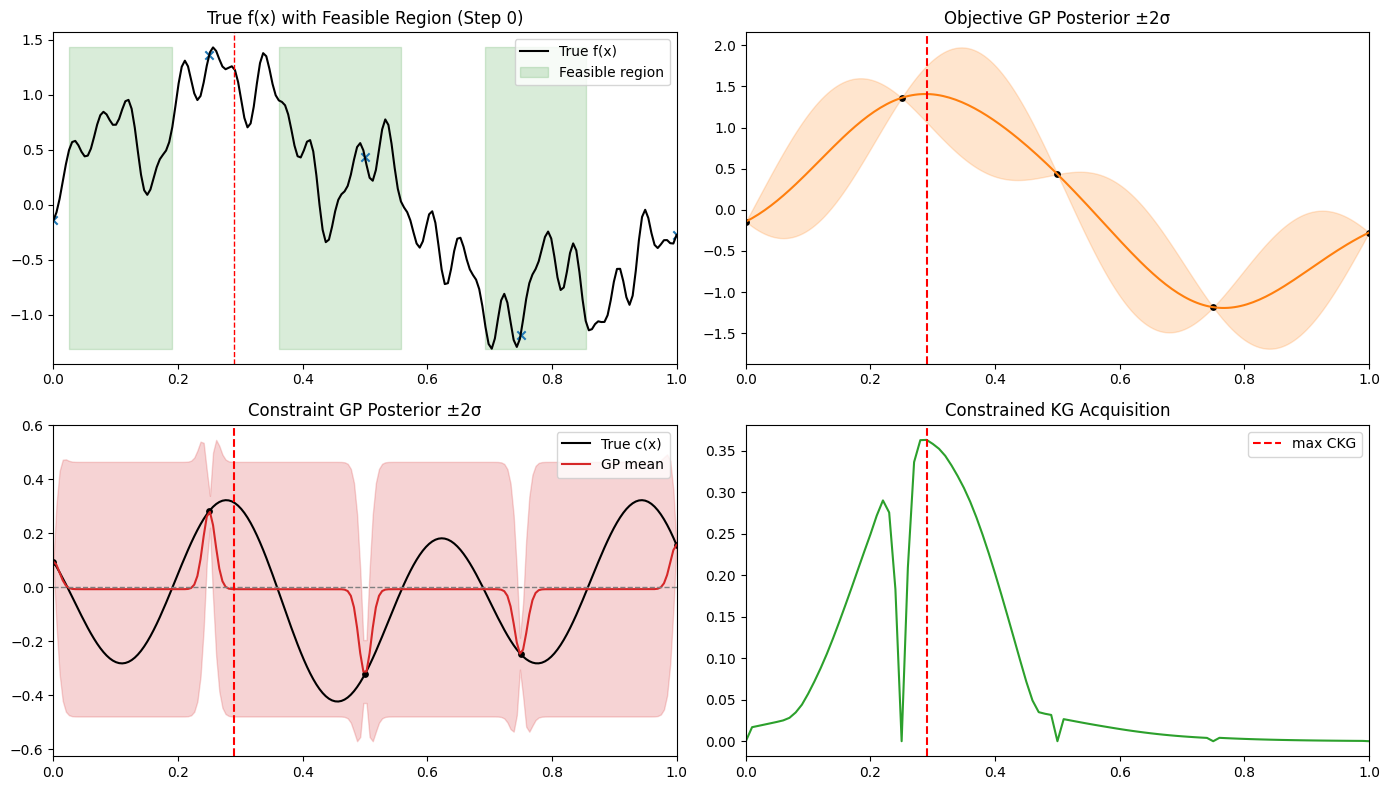

--- Step 2/8 ---
x_next=0.410, f(x)=0.595, c(x)=-0.308


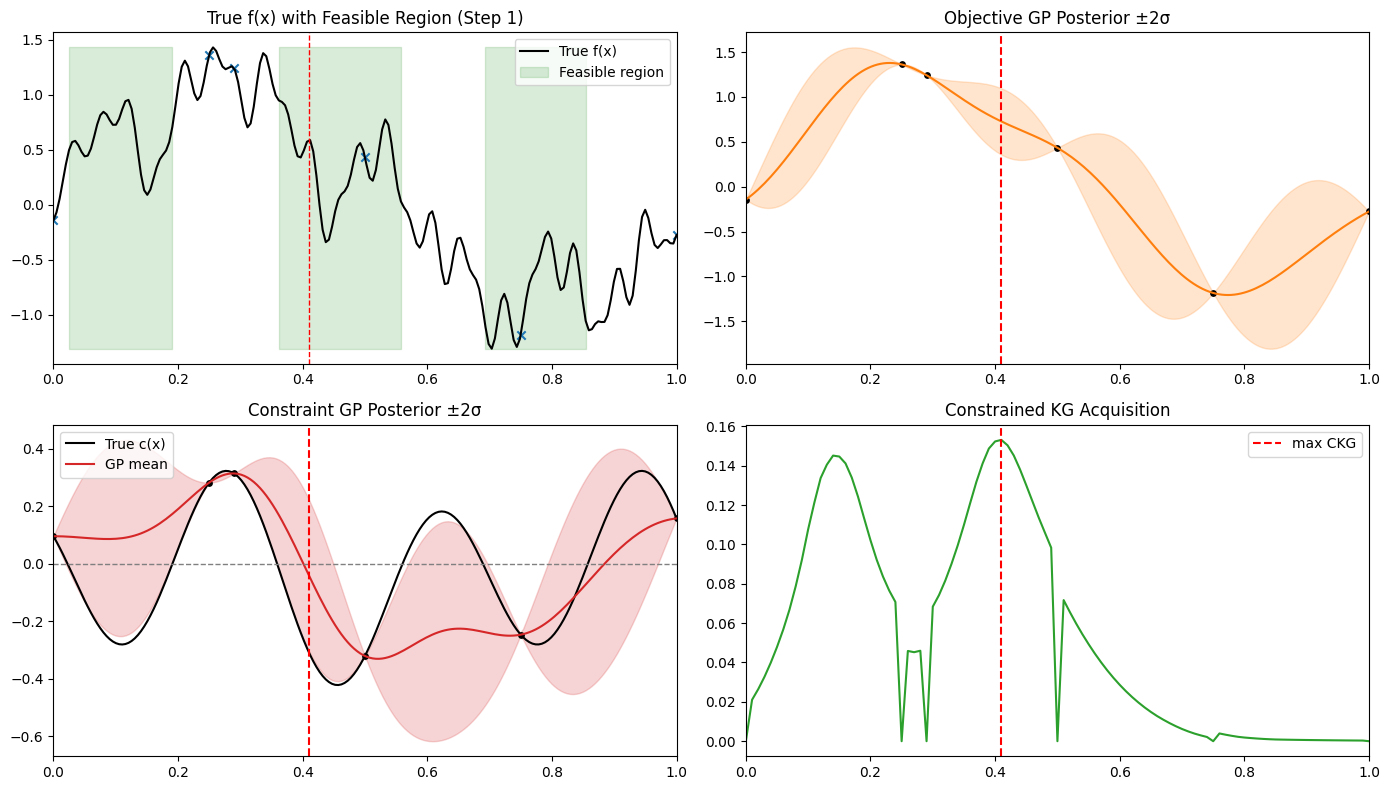

--- Step 3/8 ---
x_next=0.160, f(x)=0.221, c(x)=-0.162


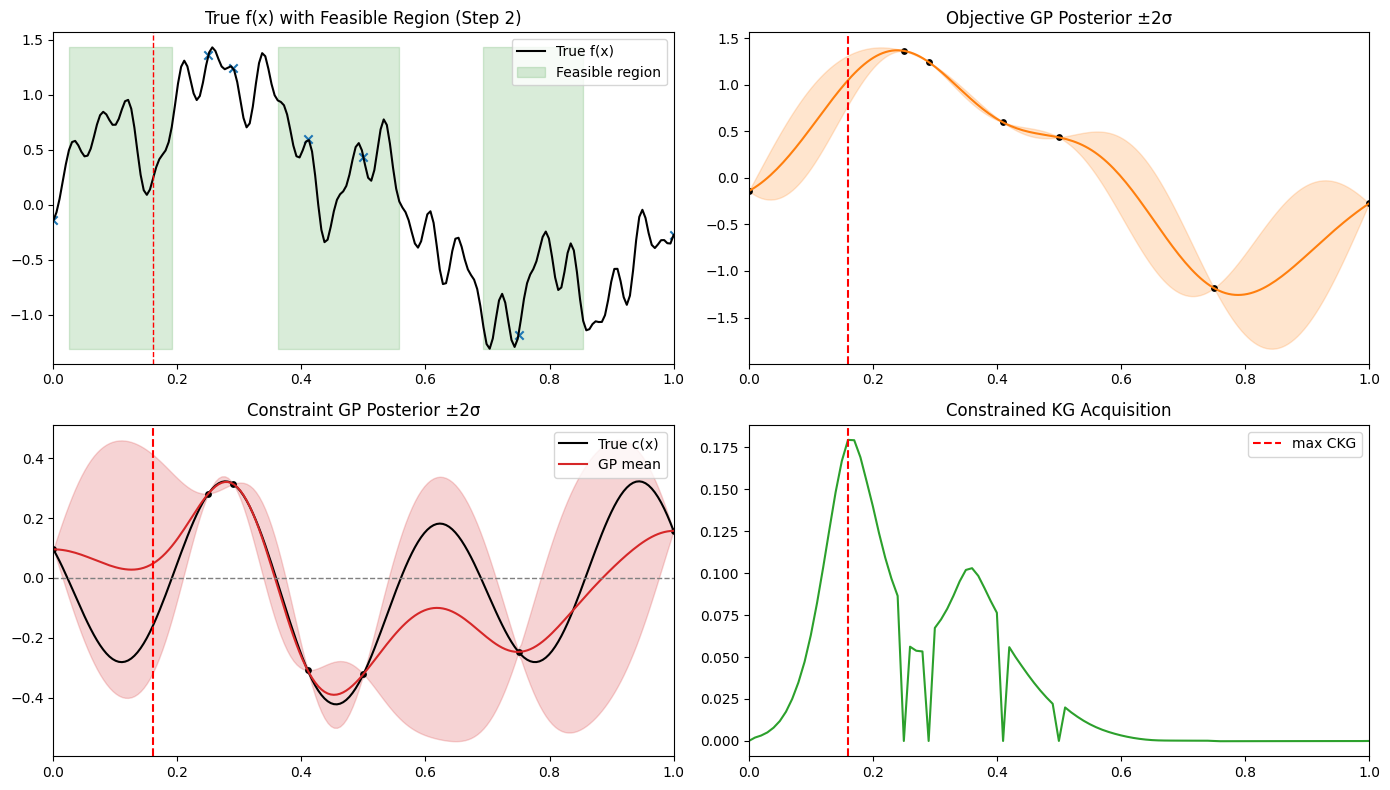

--- Step 4/8 ---
x_next=0.200, f(x)=1.064, c(x)=0.050


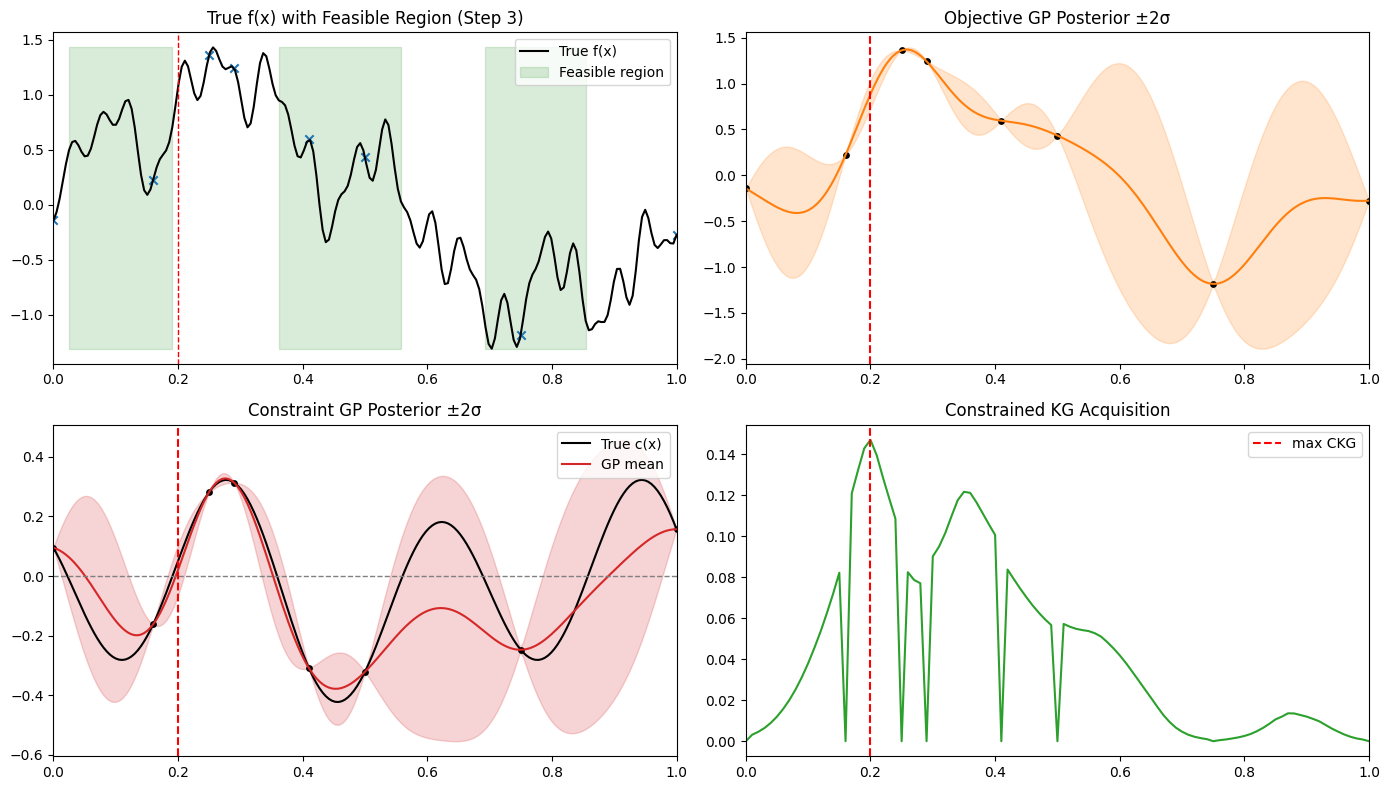

--- Step 5/8 ---
x_next=0.360, f(x)=0.961, c(x)=-0.006


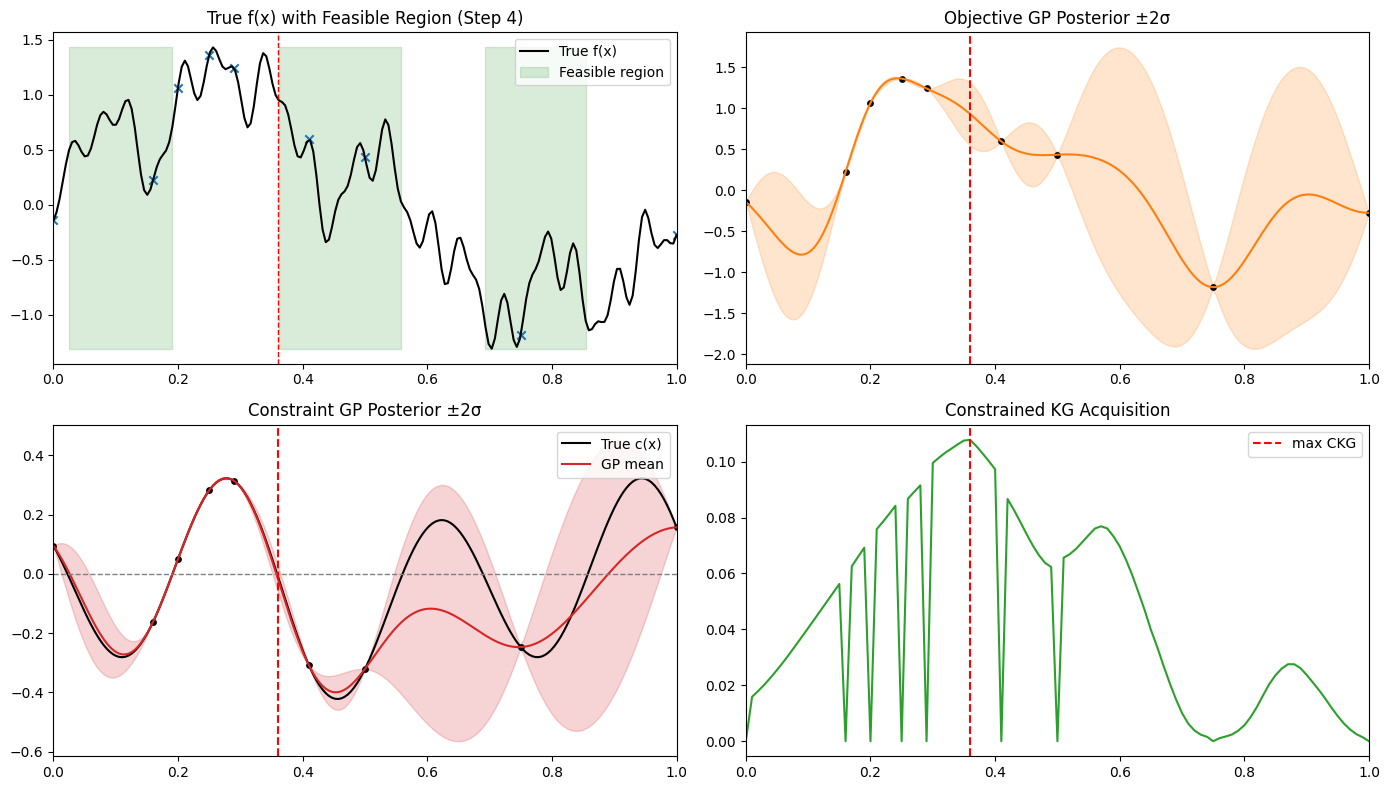

--- Step 6/8 ---
x_next=0.580, f(x)=-0.297, c(x)=0.091


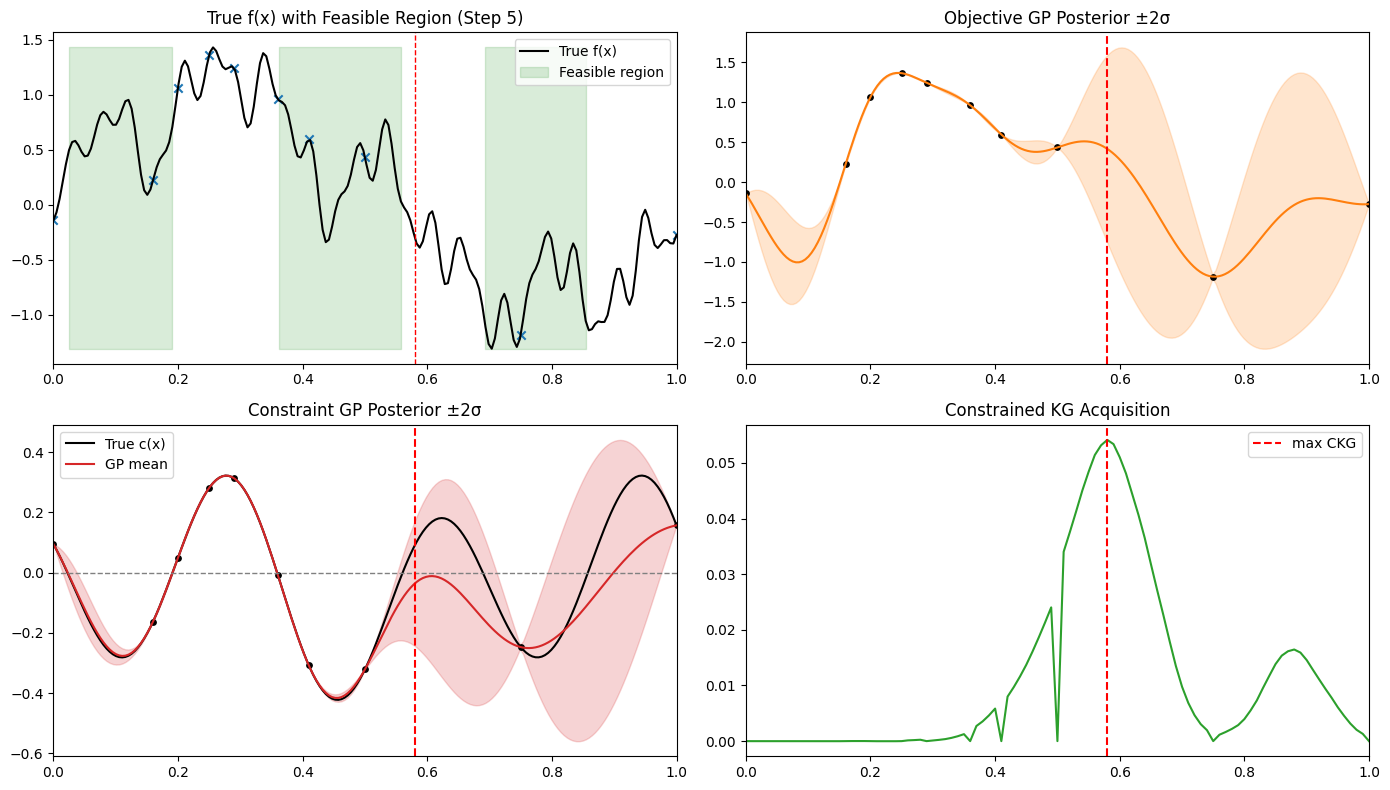

--- Step 7/8 ---
x_next=0.880, f(x)=-1.069, c(x)=0.124


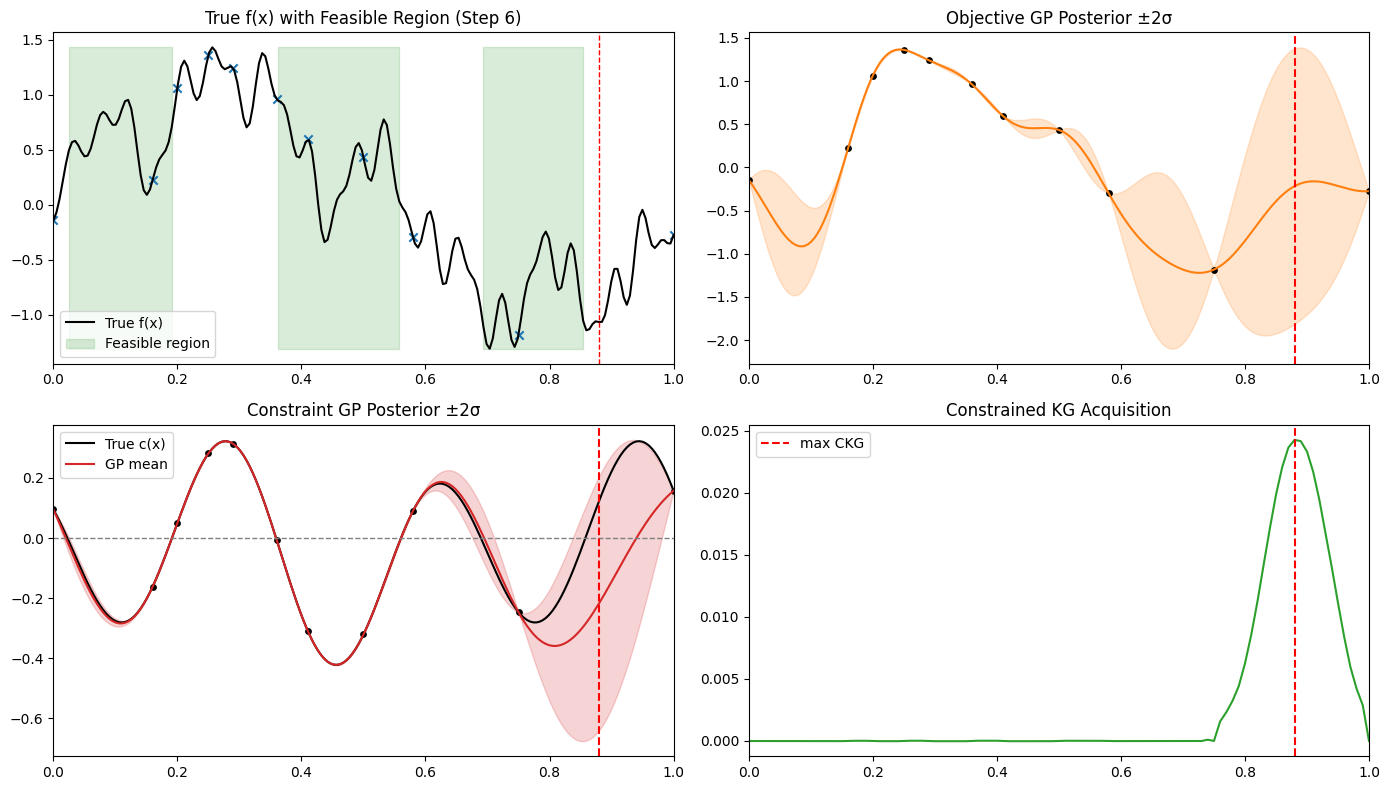

--- Step 8/8 ---
x_next=0.370, f(x)=0.921, c(x)=-0.072


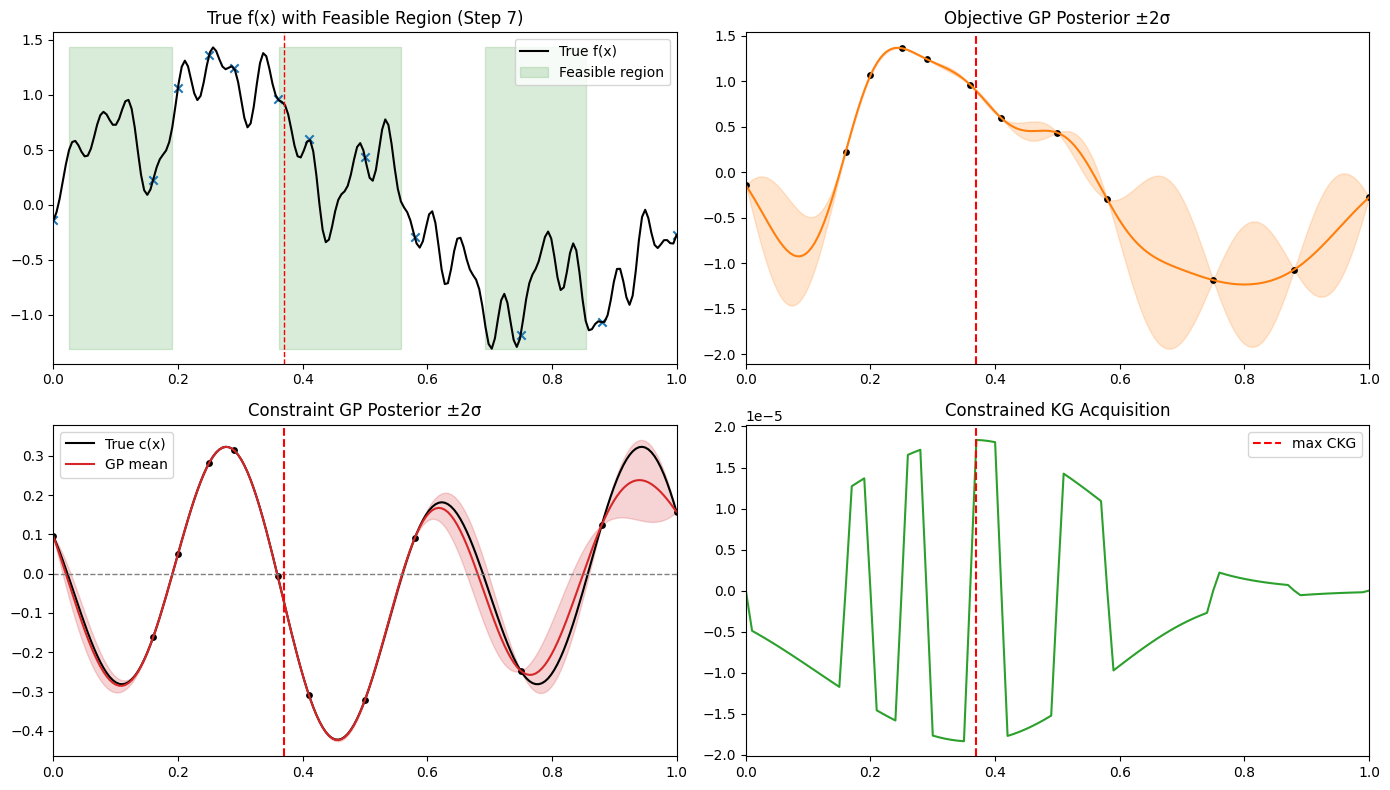

Theoretical feasible optimum: x*=0.359, f(x*)=0.968


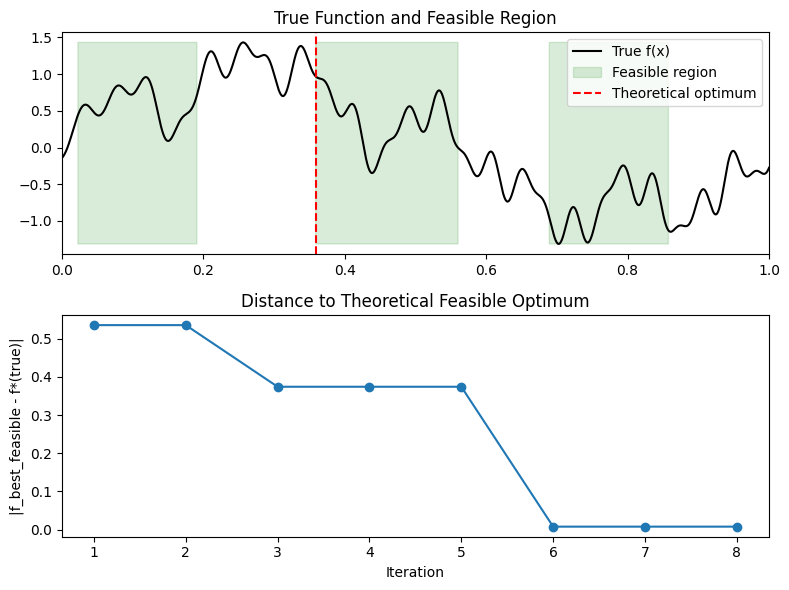

In [7]:
bo = BayesianOptimizer(f, constraint=c, n_steps=8, init_points=5, m_mc=1000)
bo.run()